# <a id="contents"></a> Table of Contents

1. [Research Question](#research-question)
2. [Import Libraries](#imports)
3. [Standardizing Data](#standardizing-data)
4. [Loading Position Data](#loading-data)
5. [Descriptive Statistics and Visualization](#descriptive-stats)
   - 5.1 [Descriptive Statistics Calculation](#descriptive-stats-calc)
   - 5.2 [Displaying Descriptive Statistics as Heatmap](#descriptive-stats-heatmap)
6. [Distribution and Box Plot Visualization](#distribution-and-box-plot)
7. [Correlation Heatmaps](#correlation-heatmaps)
8. [Principal Component Analysis](#PCA)
   - 8.1 [Defense PCA](#defense-pca)
   - 8.2 [Midfileder PCA](#midfielder-pca)
   - 8.3 [Goalkeeper PCA](#goalkeeper-pca)
   - 8.4 [Forward PCA](#forward-pca)
9. [PCA and Baseline Models](#baseline-models)
   - 9.1 [Defense PCA and Model Baselines](#baseline-models-defense)
      - 9.1.A [Decision Tree](#baseline-models-defense-dt)
      - 9.1.B [Bagging](#baseline-models-defense-bagging)
      - 9.1.C [Linear Regression](#baseline-models-defense-logreg)
   - 9.2 [Midfielder PCA and Model Baselines](#baseline-models-midfielder)
      - 9.2.A [Decision Tree](#baseline-models-midfielder-dt)
      - 9.2.B [Bagging](#baseline-models-midfielder-bagging)
      - 9.2.C [Linear Regression](#baseline-models-midfielder-logreg)
   - 9.3 [Goalkeeper PCA and Model Baselines](#baseline-models-goalkeeper)
      - 9.3.A [Decision Tree](#baseline-models-goalkeeper-dt)
      - 9.3.B [Bagging](#baseline-models-goalkeeper-bagging)
      - 9.3.C [Linear Regression](#baseline-models-goalkeeper-logreg)
   - 9.4 [Forward PCA and Model Baselines](#baseline-models-forward)
      - 9.4.A [Decision Tree](#baseline-models-forward-dt)
      - 9.4.B [Bagging](#baseline-models-forward-bagging)
      - 9.4.C [Linear Regression](#baseline-models-forward-logreg)


<a id="research-question"></a>

## <div class='section'>Section 1: Research Question</div>


Our main research question is: How can players' skills across different positions in the top five European soccer leagues, derived from performance metrics, be used to predict their salaries? For our final project, we utilized data scraped from FBref.com to perform a Principal Component Analysis to explore similarities across top players and their respective positions.

<a id="imports"></a>

## <div class='section'>Section 2: Import Libraries</div>


In [1]:
import itertools
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
                            roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, \
                        GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier


# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

<a id="standardizing-data"></a>

## <div class='section'>Section 3: Standardizing and Preprocessing Data</div>

[Return to contents](#contents)

Here, we define a `standardize` function that will be used to scale and standardize the data to ensure that each feature contributes equally to any subsequent analysis so that we can avoid biases due to differences in scale. Since our project involves the use of PCA, it is essential to standardize the data to ensure that each predictor contributes equally and without bias to the principal components.

In [2]:
scaler = StandardScaler()
def standardize(df):
    
    if 'Player' in df.columns:
        player_column = df['Player']

    if 'Squad' in df.columns:
        squad_column = df['Squad']

    if 'Comp' in df.columns:
        comp_column = df['Comp']
        
    numeric_columns = df.select_dtypes(include='number').columns
    standardized_data = scaler.fit_transform(df[numeric_columns])

    standardized_df = pd.DataFrame(standardized_data, columns=numeric_columns)
    standardized_df['Player'] = player_column.reset_index(drop=True)
    standardized_df['Comp'] = comp_column.reset_index(drop=True)
    standardized_df['Squad'] = squad_column.reset_index(drop=True)
    
    return standardized_df


<a id="loading-data"></a>

## <div class='section'>Section 4: Loading Position Data</div>

[Return to contents](#contents)

Here, we load and `standardize` data from CSV files for each position, then organize them in a dictionary. To improve our analysis, we seperated our data into four datasets based on the four different player positions. This distinction is important since the relevant player statistics for different positions (e.g. outfielder vs. goalkeeper) are very different, and would therefore distort our PCA if left combined. Additionally, we rename the predictors to ease interpretability within our notebook.

In [3]:
# Make dataframes
goalkeepers = pd.read_csv("stats/GK_relevant_stats.csv")
defenders = pd.read_csv("stats/DF_relevant_stats.csv")
midfielders = pd.read_csv("stats/MF_relevant_stats.csv")
forwards = pd.read_csv("stats/FW_relevant_stats.csv")
salaries = pd.read_csv('stats/salaries.csv')

# Dictionary of dataframes for each position
dataframes = {
    'Goalkeepers': goalkeepers, 
    'Defenders': defenders, 
    'Midfielders': midfielders, 
    'Forwards': forwards
}

column_mapping = {
    'MP': 'Matches Played',
    'Starts': 'Starts',
    'Min': 'Minutes Played',
    '90s': '90-Minute Increments',
    'Gls': 'Goals',
    'Ast': 'Assists',
    'G+A': 'Goals + Assists',
    'G-PK': 'Goals (Excl. Penalties)',
    'PK': 'Penalty Goals',
    'PKatt': 'Penalty Attempts',
    'CrdY': 'Yellow Cards',
    'CrdR': 'Red Cards',
    'xG': 'Expected Goals',
    'npxG': 'Non-Penalty Expected Goals',
    'xAG': 'Expected Assists',
    'npxG+xAG': 'Expected Non-Penalty Goals + Assists',
    'PrgC': 'Progressive Carries',
    'PrgP': 'Progressive Passes',
    'PrgR': 'Progressive Runs',
    'Glsp90': 'Goals per 90',
    'Astp90': 'Assists per 90',
    'G+Ap90': 'Goals + Assists per 90',
    'xGp90': 'Expected Goals per 90',
    'xAGp90': 'Expected Assists per 90',
    'xG+xAGp90': 'Expected Goals + Assists per 90',
    'npxGp90': 'Non-Penalty Goals per 90',
    'npxG+xAGp90': 'Non-Penalty Goals + Assists per 90',
    'Sh': 'Shots',
    'SoT': 'Shots on Target',
    'SoT%': 'Shots on Target %',
    'Sh/90': 'Shots per 90',
    'SoT/90': 'Shots on Target per 90',
    'ShDist': 'Average Shot Distance',
    'npxG/Sh': 'Non-Penalty xG per Shot',
    'G-xG': 'Goals Minus xG',
    'Cmp': 'Passes Completed',
    'Att': 'Passes Attempted',
    'Cmp%': 'Pass Completion %',
    'PTotDist': 'Total Passing Distance',
    'PPrgDist': 'Progressive Passing Distance',
    'A-xAG': 'Assists Minus xAG',
    'KP': 'Key Passes',
    '1/3': 'Passes into Final Third',
    'PPA': 'Passes into Penalty Area',
    'Tkl': 'Tackles',
    'TklW': 'Tackles Won',
    'DTkl': 'Dribbles Tackled',
    'DTklAtt': 'Dribbles Tackled Attempts',
    'Tkl%': 'Tackle Success %',
    'Blocks': 'Blocks',
    'Int': 'Interceptions',
    'Clr': 'Clearances',
    'Touches': 'Touches',
    'Def Pen': 'Touches in Defensive Penalty Area',
    'Def 3rd': 'Touches in Defensive Third',
    'Mid 3rd': 'Touches in Midfield Third',
    'Att 3rd': 'Touches in Attacking Third',
    'Att Pen': 'Touches in Attacking Penalty Area',
    'TOAtt': 'Take-On Attempts',
    'TOSucc': 'Take-On Successes',
    'TOSucc%': 'Take-On Success %',
    'Tkld': 'Tackled',
    'Tkld%': 'Tackled %',
    'Carries': 'Carries',
    'CTotDist': 'Total Carry Distance',
    'CPrgDist': 'Progressive Carry Distance',
    'C1/3': 'Carries into Final Third',
    'CPA': 'Carries into Penalty Area',
    'Rec': 'Passes Received',
    'GA': 'Goals Allowed',
    'GA90': 'Goals Allowed per 90 Minutes',
    'SoTA': 'Shots on Target Against',
    'Saves': 'Saves Made',
    'Save%': 'Save Percentage',
    'CS': 'Clean Sheets',
    'CS%': 'Clean Sheet Percentage',
    'PSxG': 'Post-Shot Expected Goals',
    'PSxG/SoT': 'Post-Shot Expected Goals per Shot on Target',
    'PSxG+/-': 'Post-Shot Expected Goals Difference',
    'Opp': 'Opponent Shots',
    'Stp': 'Crosses Stopped',
    'Stp%': 'Crosses Stopped Percentage'
}

defenders.rename(columns=column_mapping, inplace=True)
goalkeepers.rename(columns=column_mapping, inplace=True)
midfielders.rename(columns=column_mapping, inplace=True)
forwards.rename(columns=column_mapping, inplace=True)

team_mean_salary = salaries[salaries['Annual Wage (Euros)'] > 0].groupby('Squad')['Annual Wage (Euros)'].mean()

# Replace 0 salaries with the corresponding team's mean salary


for key in dataframes.keys():
    df1 = dataframes[key]
    merged = df1.merge(salaries, on=['Player', 'Squad'], how='left', suffixes=('_df1', '_df2')).fillna(0)

    # Update df1 'Goals' column with the 'Goals_df2' values from df2 where matches exist
    dataframes[key]['Annual Wage (Euros)'] = merged['Annual Wage (Euros)']

    # Replace missing salaries with team's average
    dataframes[key]['Annual Wage (Euros)'] = dataframes[key].apply(
        lambda row: team_mean_salary[row['Squad']] if row['Annual Wage (Euros)'] == 0 else row['Annual Wage (Euros)'], axis=1
    )

goalkeepers = standardize(goalkeepers)
defenders = standardize(defenders)
midfielders = standardize(midfielders)
forwards = standardize(forwards)

# Numerate leagues for regression
league_map = {
    'Premier League' : 0,
    'La Liga' : 1,
    'Bundesliga' : 2,
    'Serie A' : 3,
    'Ligue 1' : 4
}

defenders['Comp'] = defenders['Comp'].map(league_map)
goalkeepers['Comp'] = goalkeepers['Comp'].map(league_map)
midfielders['Comp'] = midfielders['Comp'].map(league_map)
forwards['Comp'] = forwards['Comp'].map(league_map)

In [4]:
forwards.head()

,Age,Born,Matches Played,Starts,Minutes Played,90-Minute Increments,Goals,Assists,Goals + Assists,Goals (Excl. Penalties),Penalty Goals,Penalty Attempts,Yellow Cards,Red Cards,Expected Goals,Non-Penalty Expected Goals,Expected Assists,Expected Non-Penalty Goals + Assists,Goals per 90,Assists per 90,Goals + Assists per 90,Expected Goals per 90,Expected Assists per 90,Expected Goals + Assists per 90,Non-Penalty Goals per 90,...,Passes into Final Third,Passes into Penalty Area,Progressive Carries,Progressive Runs,Touches,Touches in Defensive Penalty Area,Touches in Defensive Third,Touches in Midfield Third,Touches in Attacking Third,Touches in Attacking Penalty Area,Take-On Attempts,Take-On Successes,Take-On Success %,Tackled,Tackled %,Carries,Total Carry Distance,Progressive Carry Distance,Carries into Final Third,Carries into Penalty Area,Passes Received,Annual Wage (Euros),Player,Comp,Squad
0,-1.613,1.464,-1.493,-1.034,-1.129,-1.130,-0.750,-0.703,-0.800,-0.767,-0.351,-0.388,-0.868,-0.282,-0.826,-0.860,-0.823,-0.922,-0.678,-0.291,-0.656,-1.200,-0.638,-1.302,-1.190,...,-0.838,-0.784,-0.801,-1.011,-1.056,-0.900,-0.958,-1.059,-1.001,-0.988,-0.870,-0.821,NaN,-0.897,NaN,-1.023,-0.924,-0.834,-0.848,-0.739,-1.038,-0.418,Aaron Malouda,4,Lille
1,0.642,-0.569,-0.220,-0.563,-0.429,-0.426,-0.548,-0.703,-0.651,-0.538,-0.351,-0.388,-0.414,-0.282,-0.603,-0.601,-0.475,-0.606,-0.299,-0.291,-0.412,-0.553,-0.189,-0.527,-0.498,...,-0.348,-0.712,-0.602,-0.565,-0.385,0.303,-0.551,-0.270,-0.426,-0.394,-0.585,-0.649,-0.776,-0.510,0.766,-0.574,-0.683,-0.712,-0.706,-0.558,-0.357,-0.610,Aaron Seydel,2,Darmstadt 98
2,-0.711,0.561,-1.409,-1.034,-1.053,-1.049,-0.750,-0.703,-0.800,-0.767,-0.351,-0.388,-0.868,-0.282,-0.782,-0.809,-0.774,-0.866,-0.678,-0.291,-0.656,0.009,-0.234,-0.156,0.102,...,-0.838,-0.639,-0.602,-0.858,-0.928,-0.900,-0.917,-0.984,-0.826,-0.854,-0.766,-0.706,0.436,-0.786,0.034,-0.873,-0.763,-0.684,-0.706,-0.498,-0.901,1.222,Abde Ezzalzouli,1,Barcelona
3,-0.711,0.561,0.628,-0.469,-0.150,-0.151,-0.548,-0.703,-0.651,-0.538,-0.351,0.424,-0.414,-0.282,-0.156,-0.290,-0.674,-0.458,-0.425,-0.291,-0.493,0.138,-0.503,-0.249,-0.128,...,-0.240,-0.134,0.826,0.124,0.171,-0.252,0.223,0.066,0.216,0.162,0.424,0.385,0.009,0.373,-0.182,0.072,0.575,0.831,0.766,1.367,0.162,-0.453,Abde Ezzalzouli,1,Betis
4,-1.162,1.238,-1.493,-1.034,-1.119,-1.120,-0.750,-0.703,-0.800,-0.767,-0.351,-0.388,-0.868,-0.282,-0.826,-0.860,-0.823,-0.922,-0.678,-0.291,-0.656,-1.200,-0.638,-1.302,-1.190,...,-0.838,-0.784,-0.801,-0.998,-1.053,-0.900,-0.958,-1.059,-0.997,-0.969,-0.870,-0.821,NaN,-0.897,NaN,-1.019,-0.924,-0.834,-0.848,-0.739,-1.035,0.762,Abdellah Raihani,1,Atlético Madrid


<a id="descriptive-stats"></a>

## <div class='section'>Section 5: Descriptive Statistics and Visualization</div>

[Return to contents](#contents)

Here, we calculate and visualize descriptive statistics for each position dataset which will provide insights into the central tendency, spread, and range of values for each feature in the dataset.


<a id="descriptive-stats-calc"></a>

#### <div class='sub-section'>5.1: Descriptive Statistics Calculation</div>

Here, we calculate the mean, standard deviation, median, min, max, and range of each numeric feature in the dataset.




In [5]:
def descriptive_stats(df):
    numeric_df = df.select_dtypes(include='number')
    stats = numeric_df.describe().T  # Transpose for readability
    stats['median'] = numeric_df.median()  # Add median
    stats['range'] = stats['max'] - stats['min']  # Calculate range
    return stats[['mean', 'std', 'median', 'min', 'max', 'range']]


<a id="descriptive-stats-heatmap"></a>

#### <div class='sub-section'>5.2: Displaying Descriptive Statistics as Heatmap</div>

Here, we create heatmaps to visualize the descriptive statistics for each feature and to help us easily spot outliers, patterns, and distributions across different features.

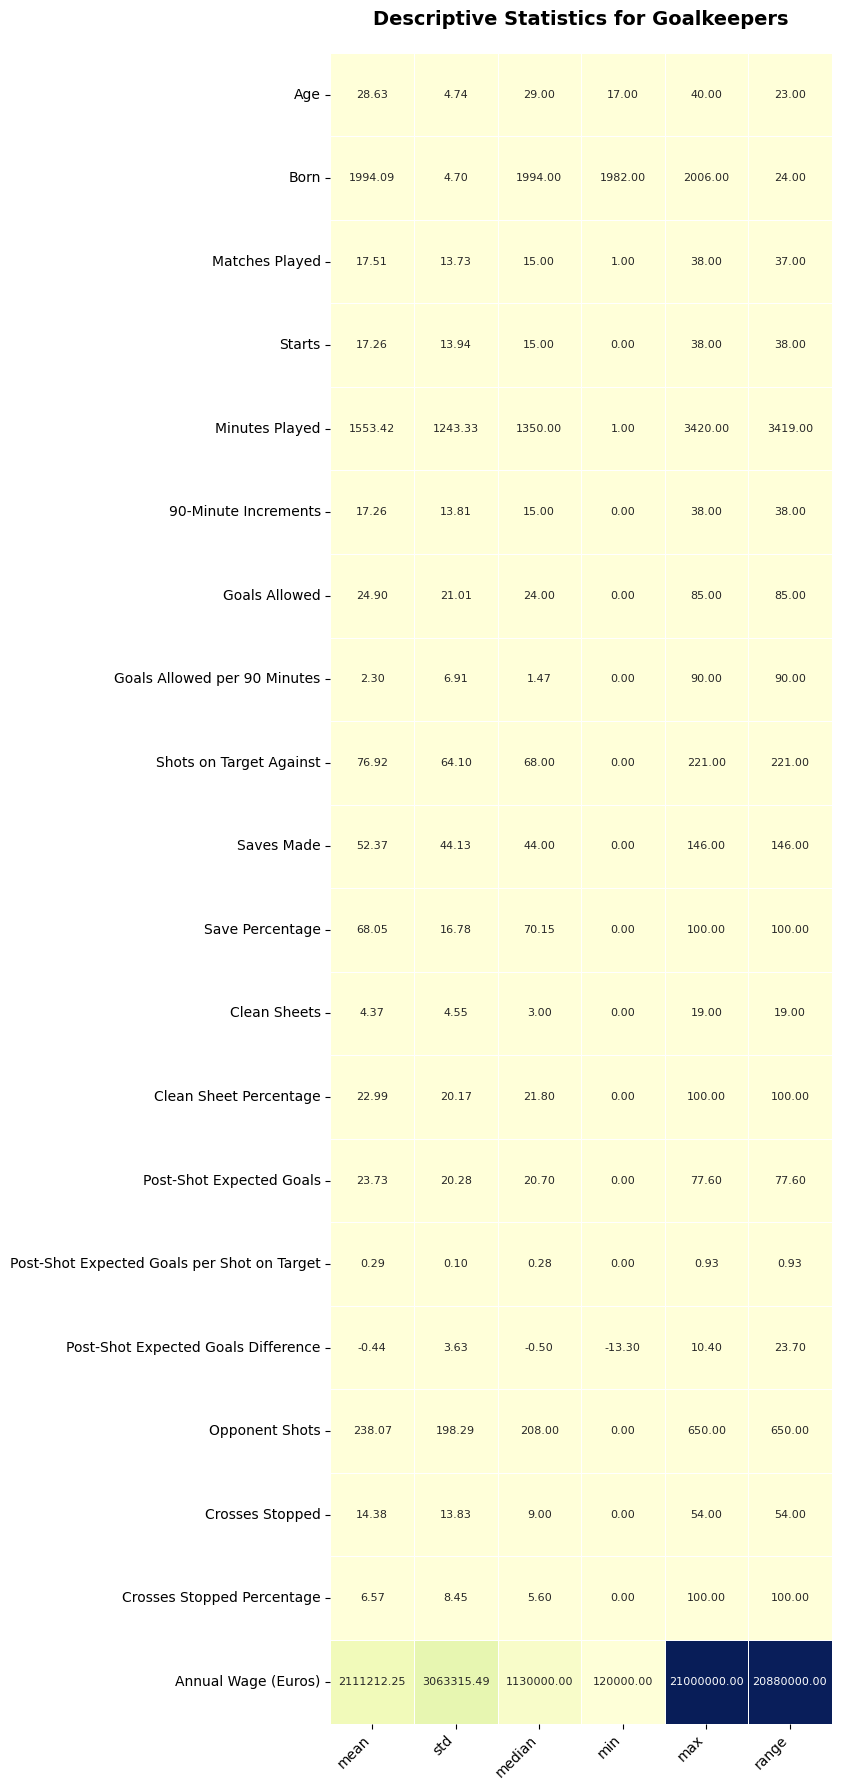

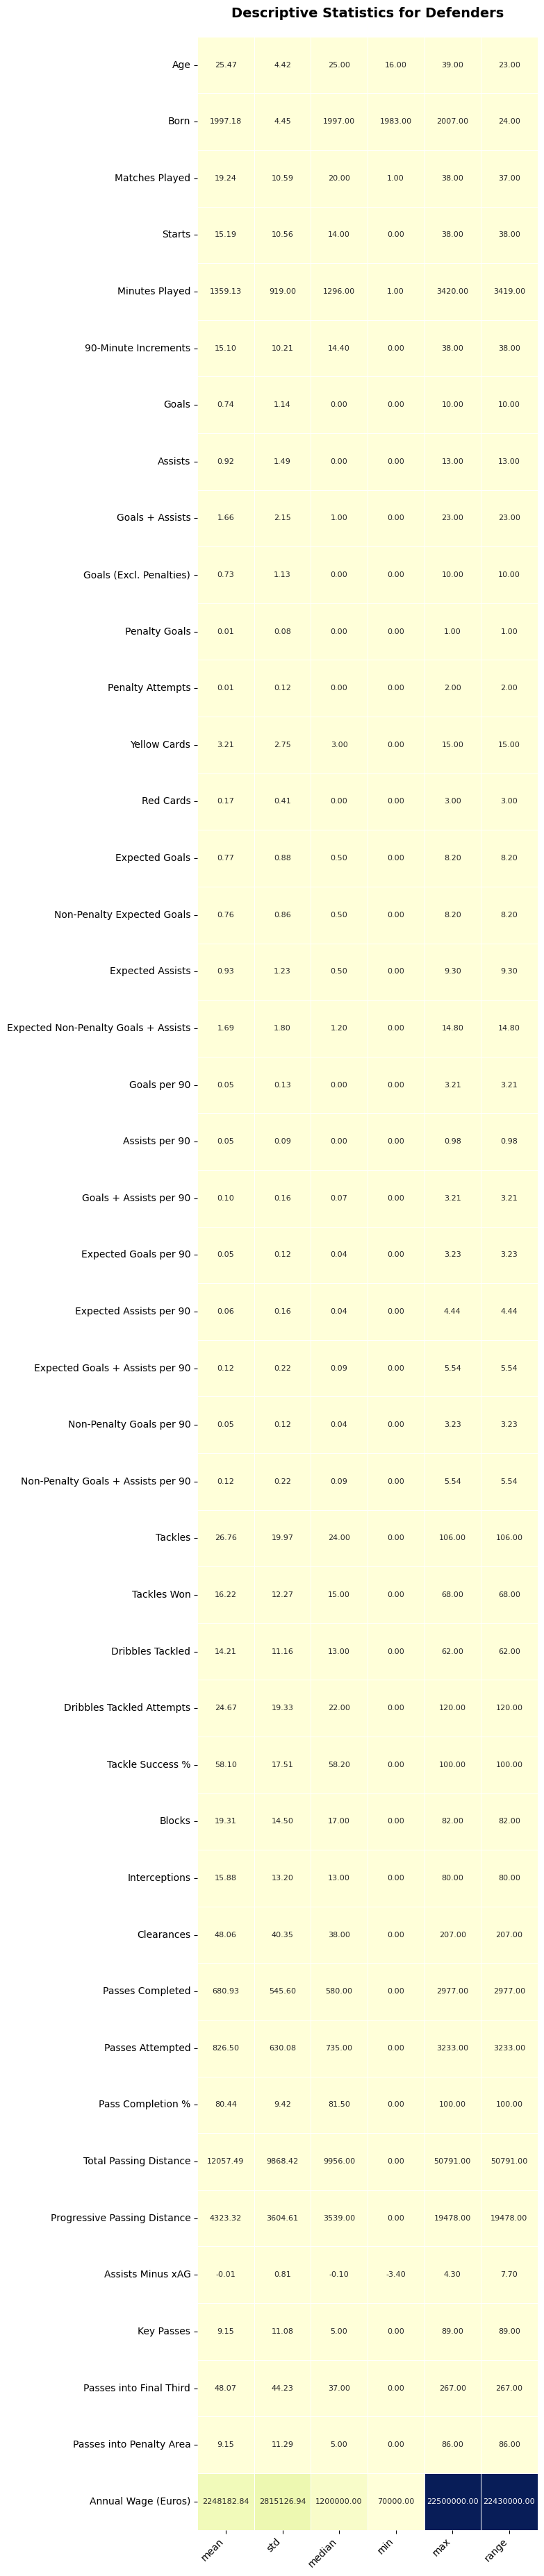

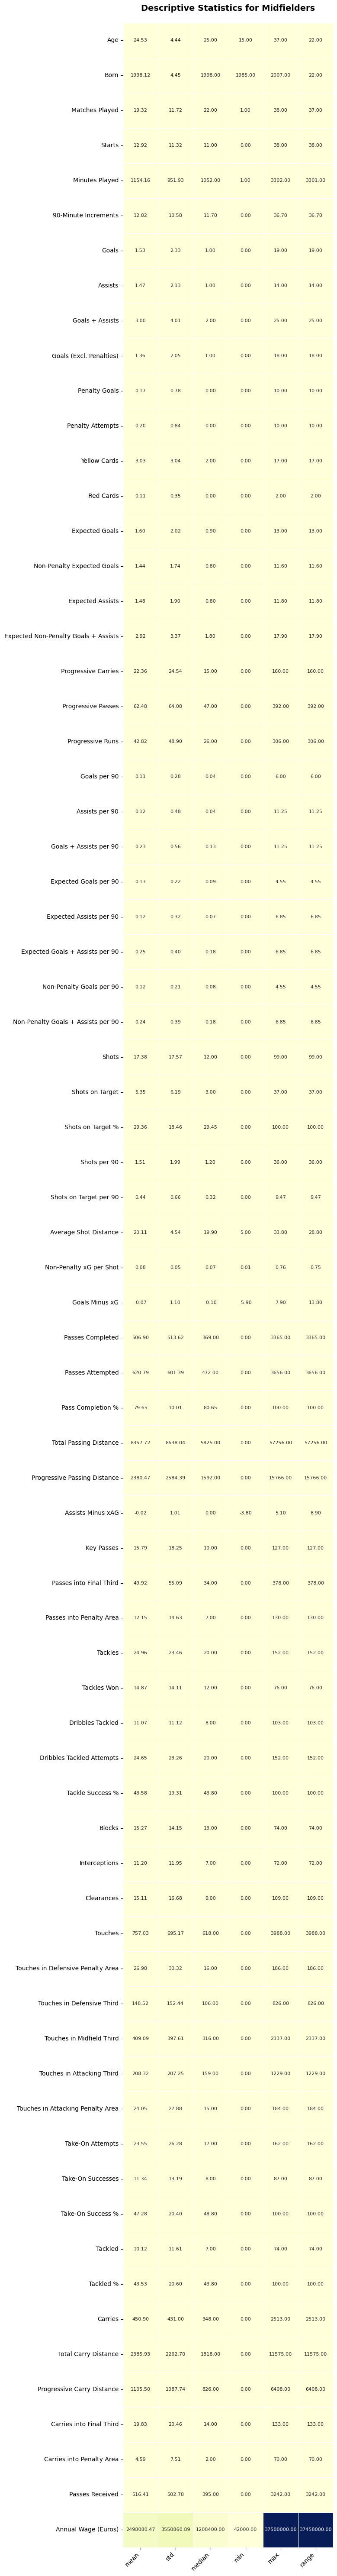

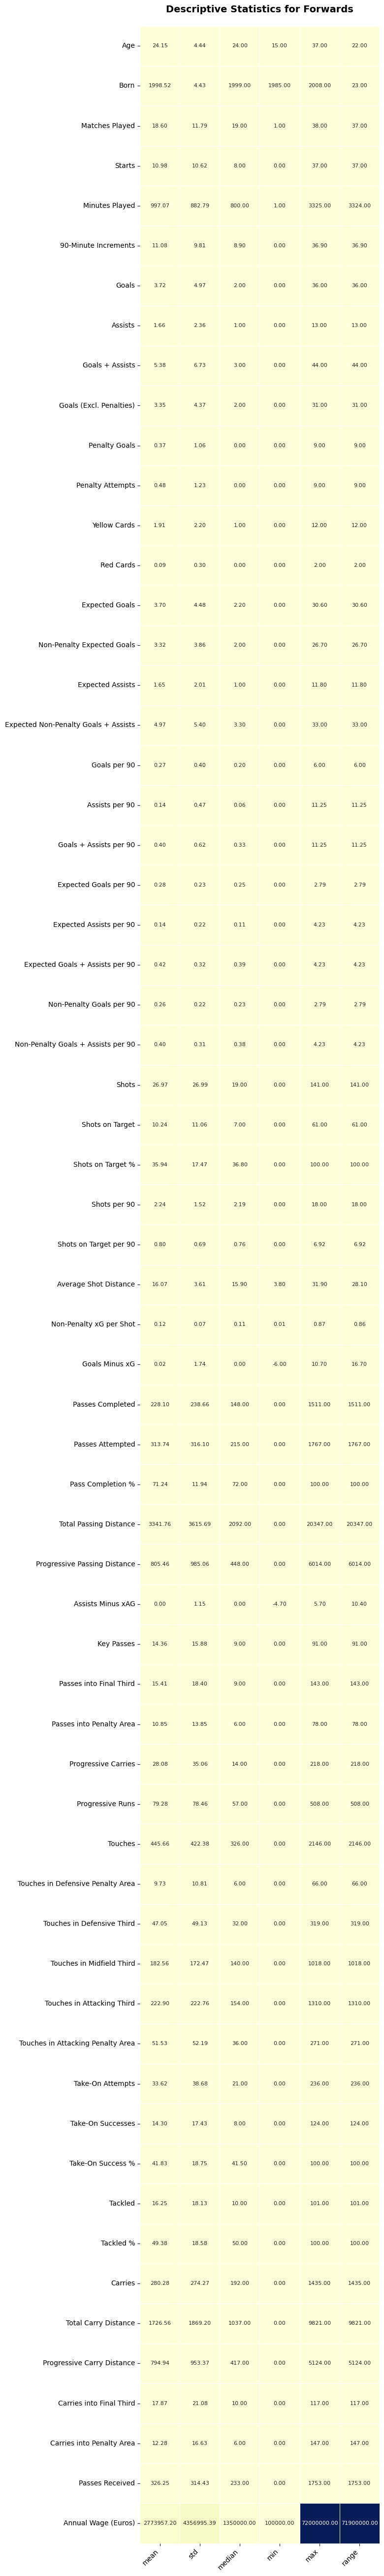

In [6]:
def display_heatmap(stats, title):
    fig, ax = plt.subplots(figsize=(12, len(stats) * 0.8 + 2))
    sns.heatmap(stats, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False, linewidths=.5, 
                annot_kws={"size": 8}, ax=ax, square=True)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.title(title, fontweight="bold", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()


# generating and displaying heatmap tables for each position's statistics
for position, df in dataframes.items():
    stats = descriptive_stats(df)
    display_heatmap(stats, f"Descriptive Statistics for {position}")


<a id="distribution-and-box-plot-visualization"></a>

## <div class='section'>Section 6: Distribution and Box Plot Visualization</div>

[Return to contents](#contents)

Here, we generate histograms and box plots for each feature to show the distribution and identify potential outliers. The histograms provide insight into how data points are distributed while box plots reveal central tendencies and variability. The histograms and box plots are then saved as PNG files in the 'plots' folder


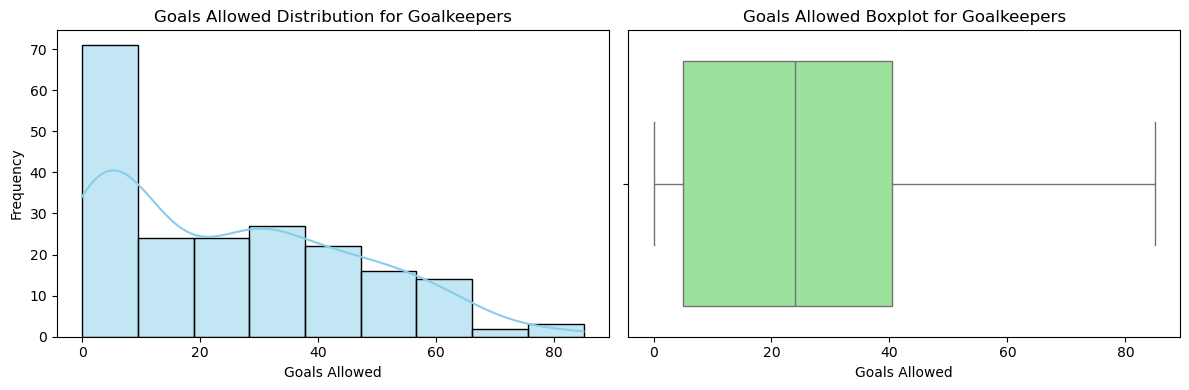

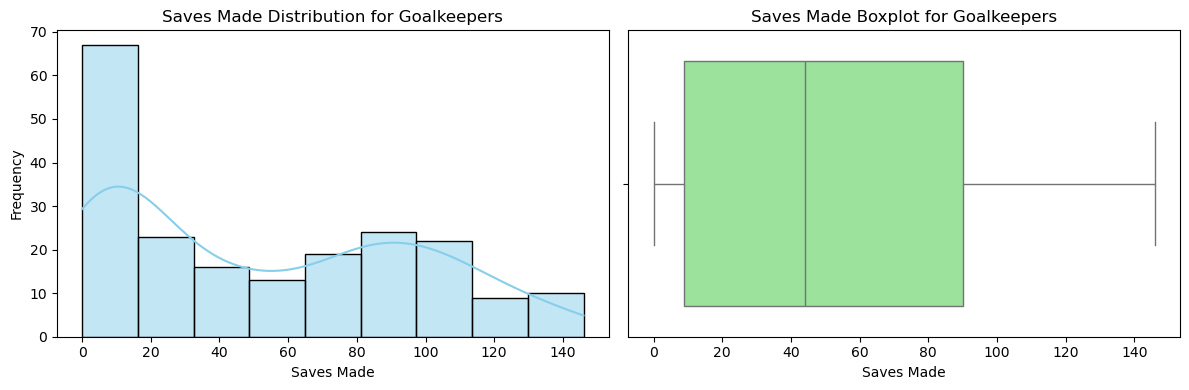

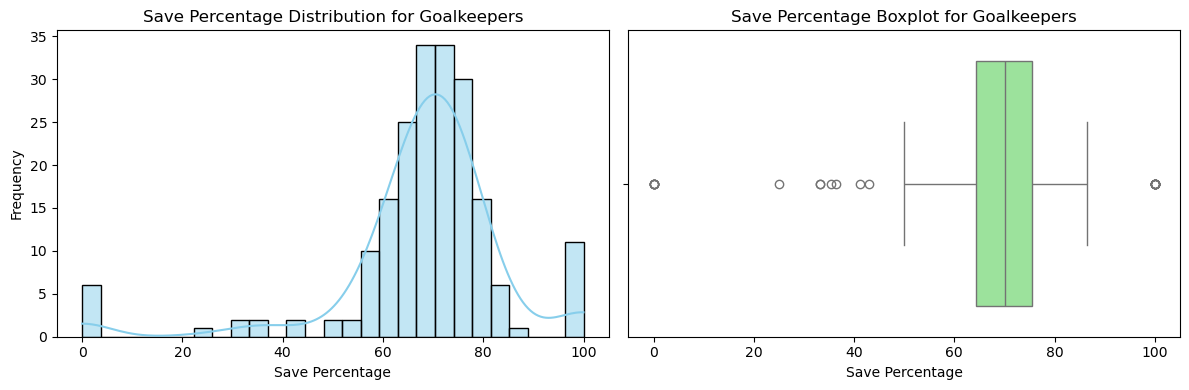

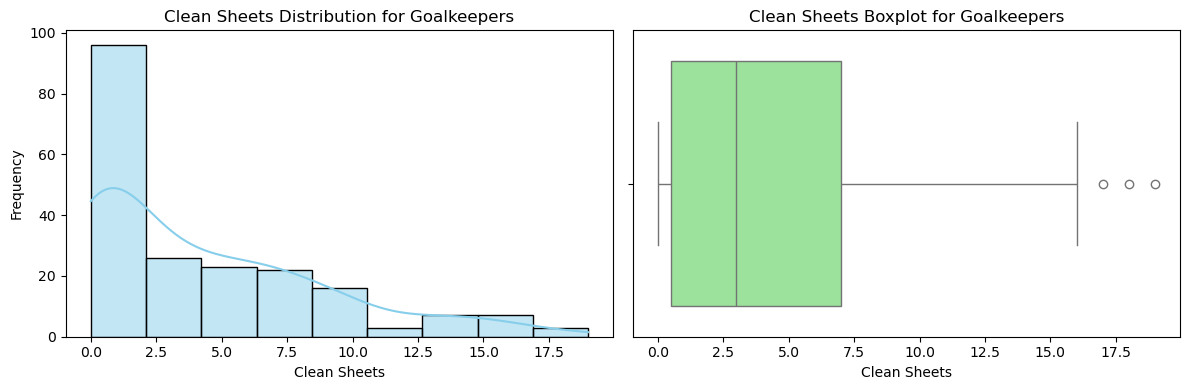

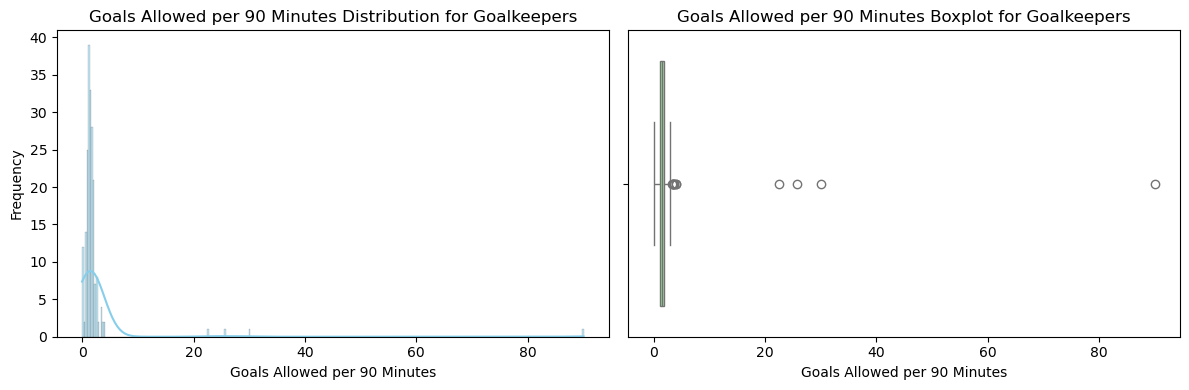

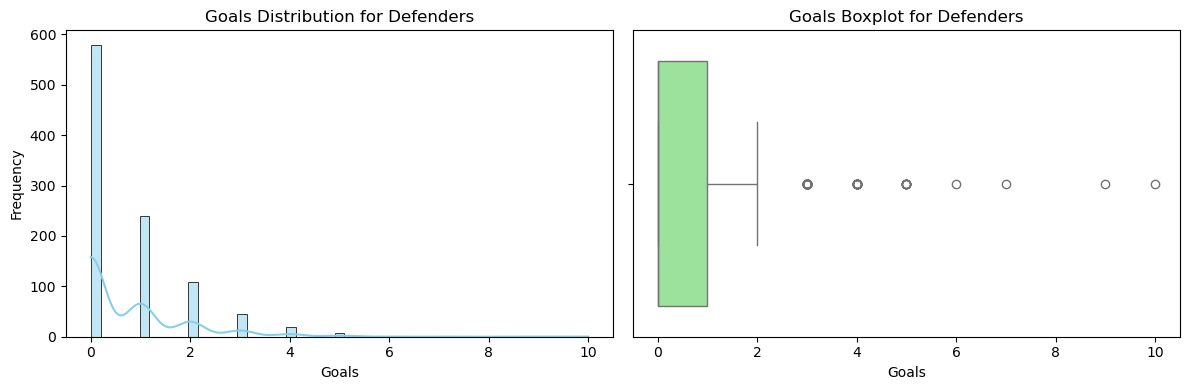

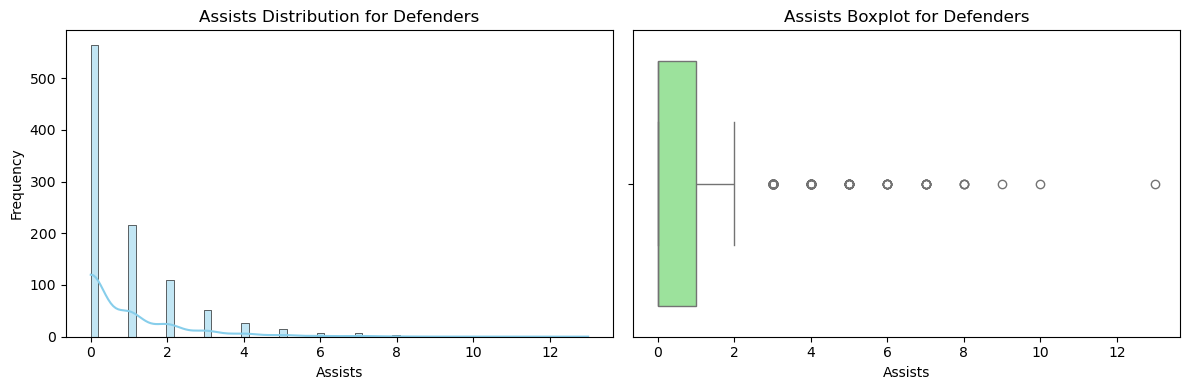

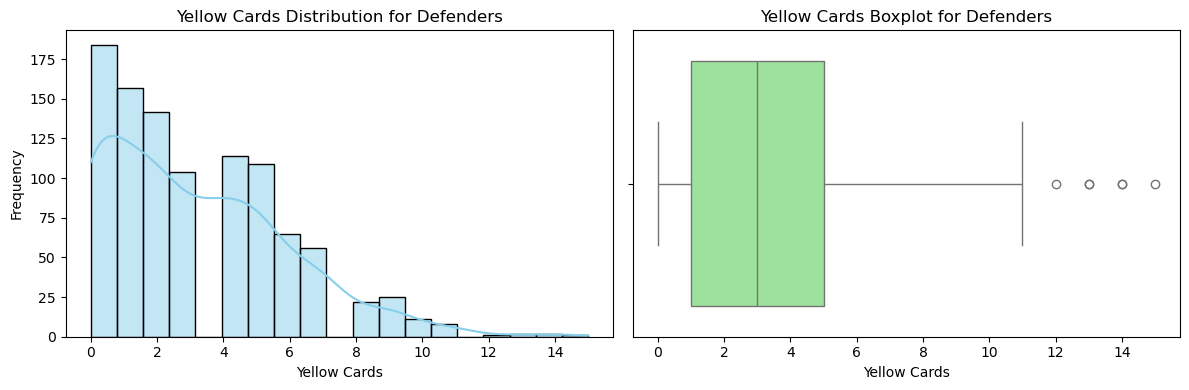

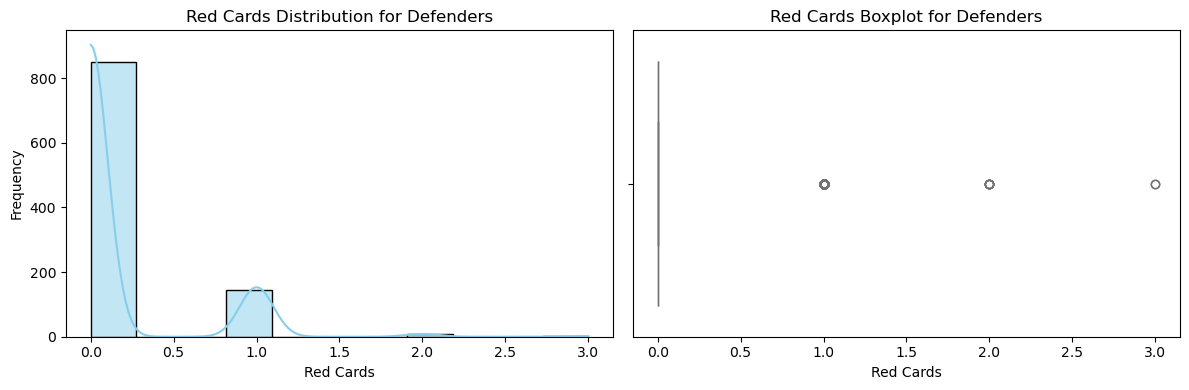

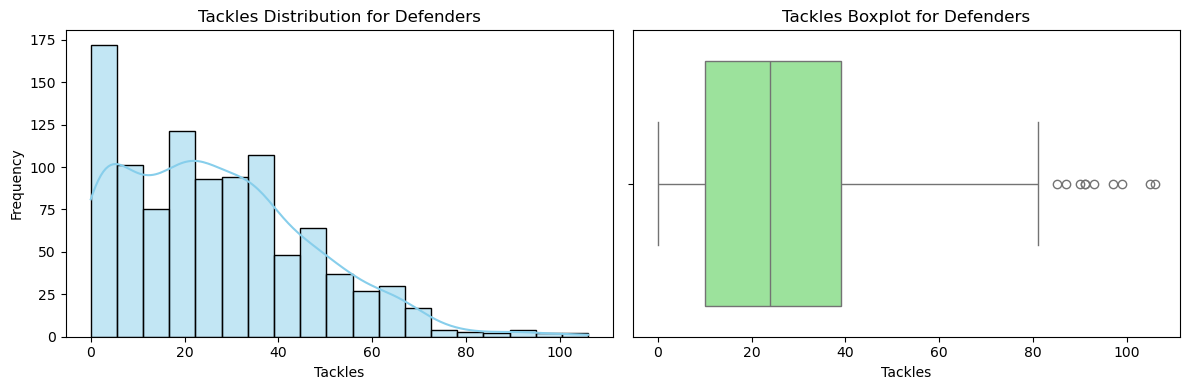

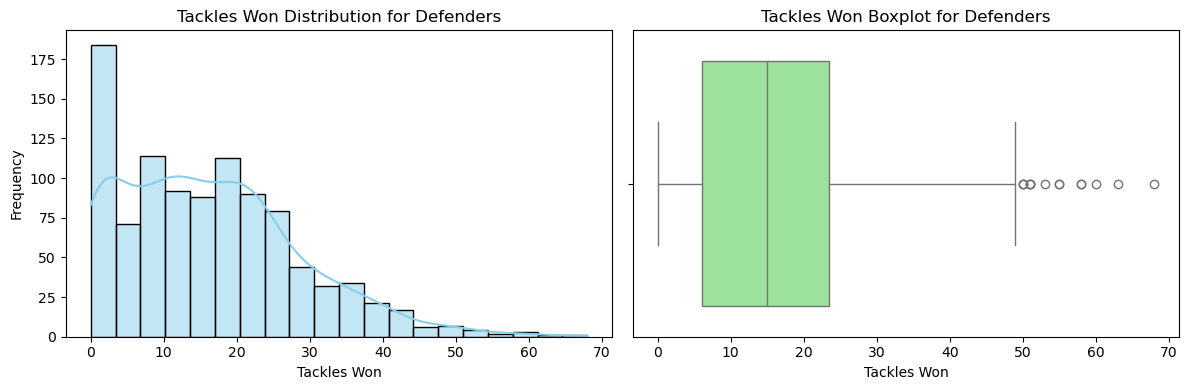

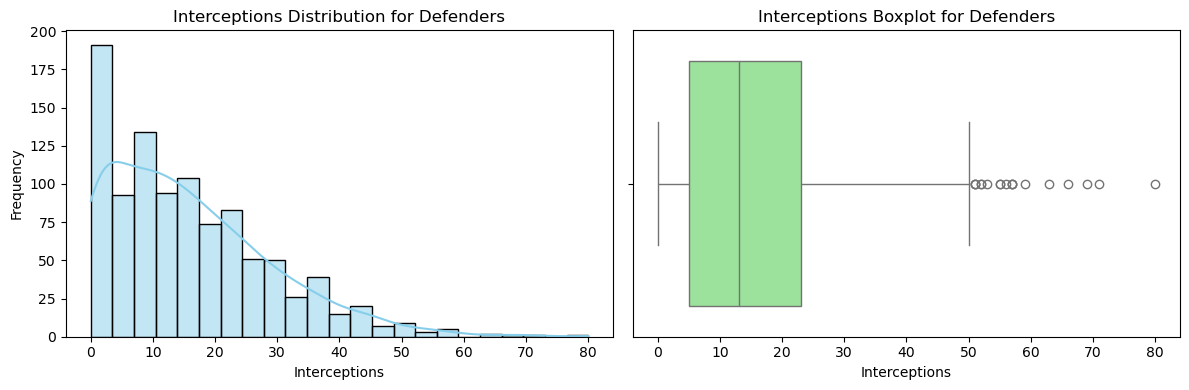

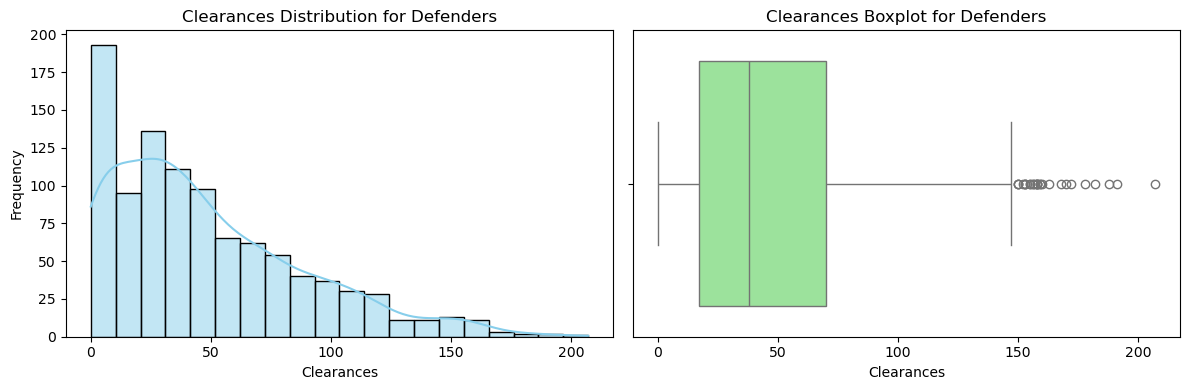

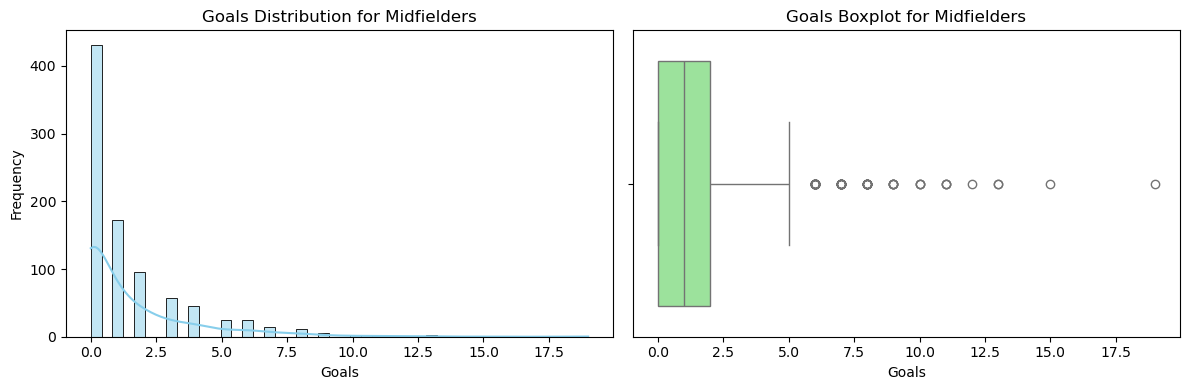

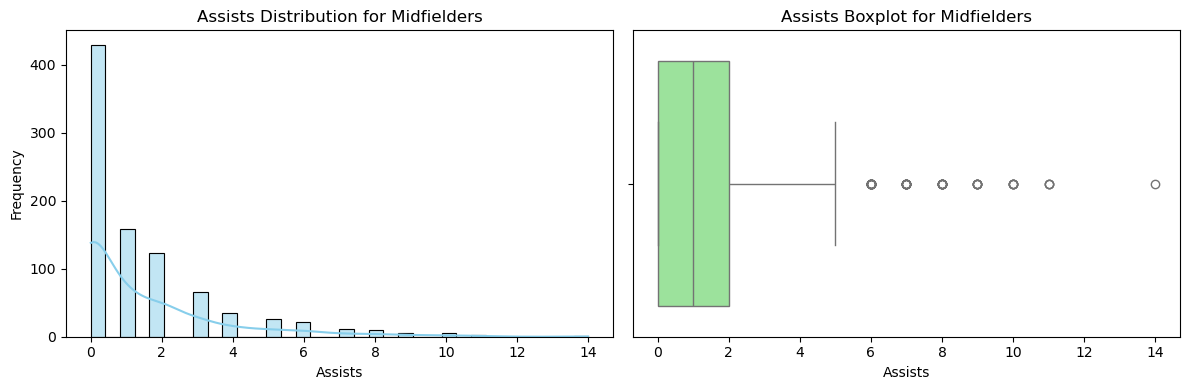

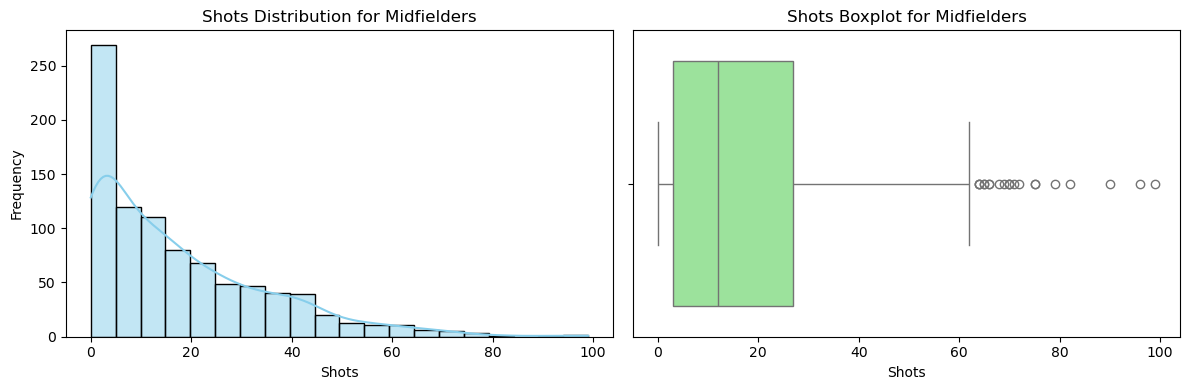

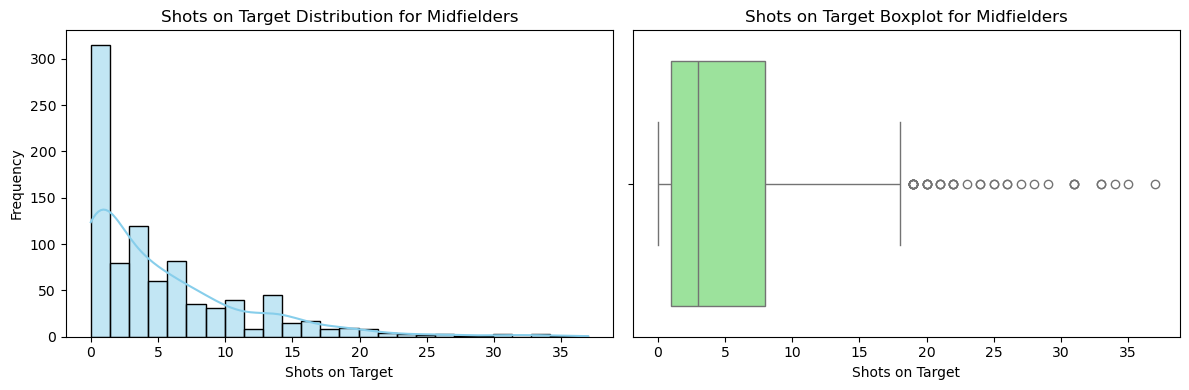

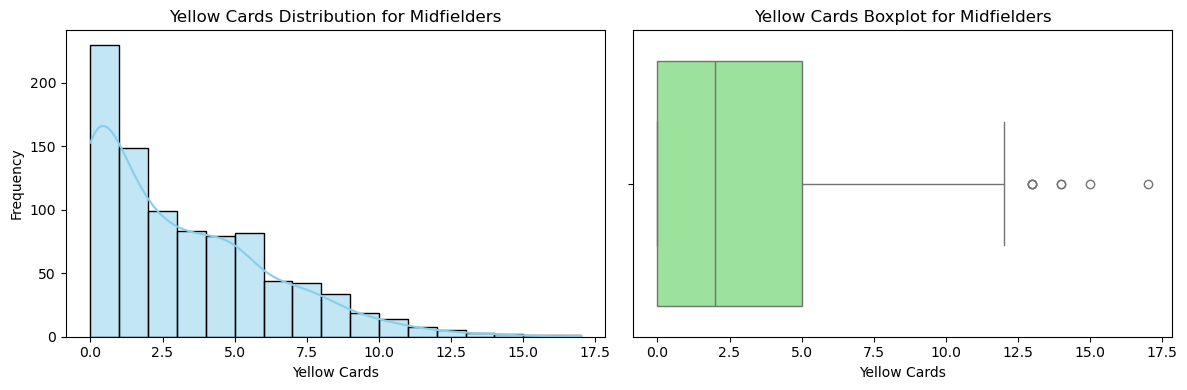

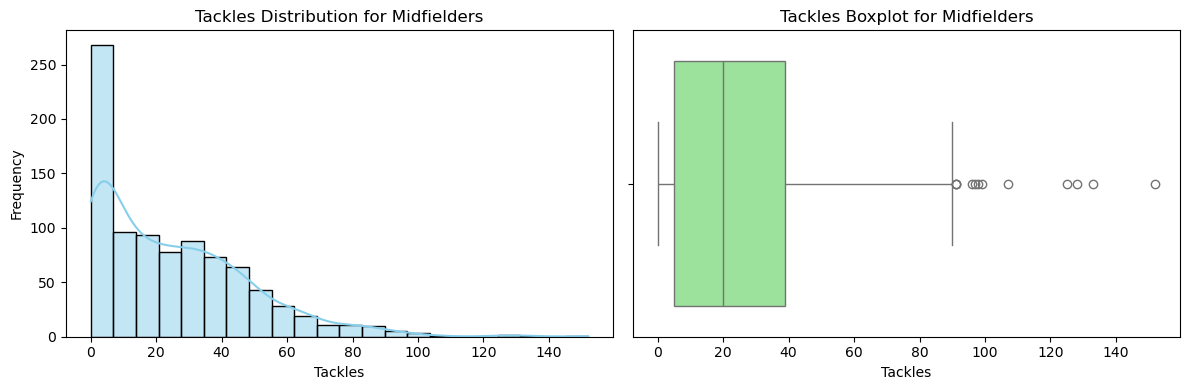

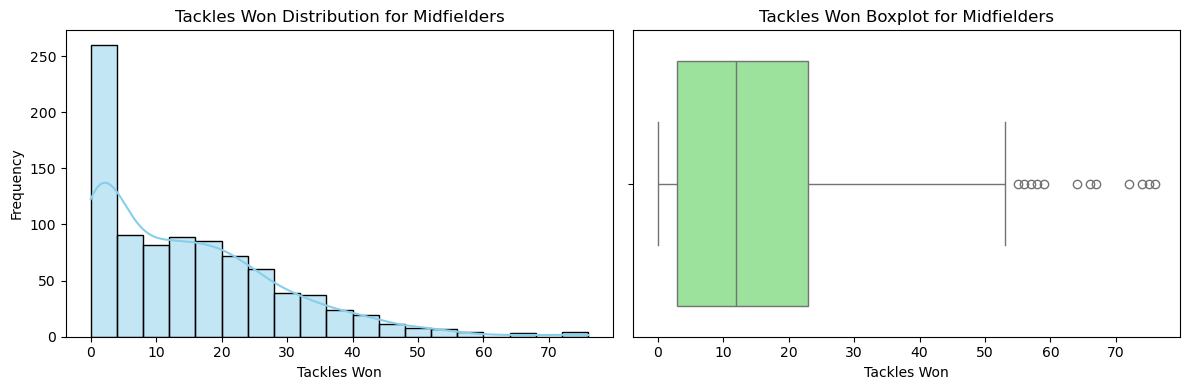

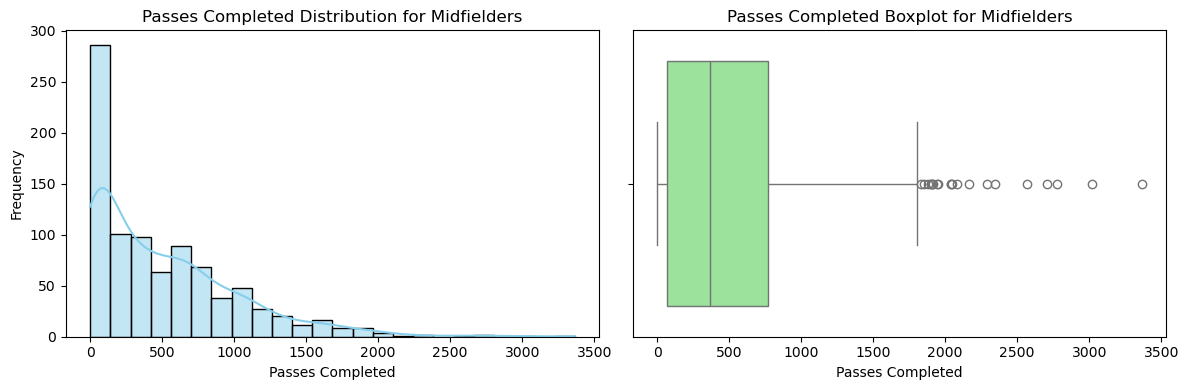

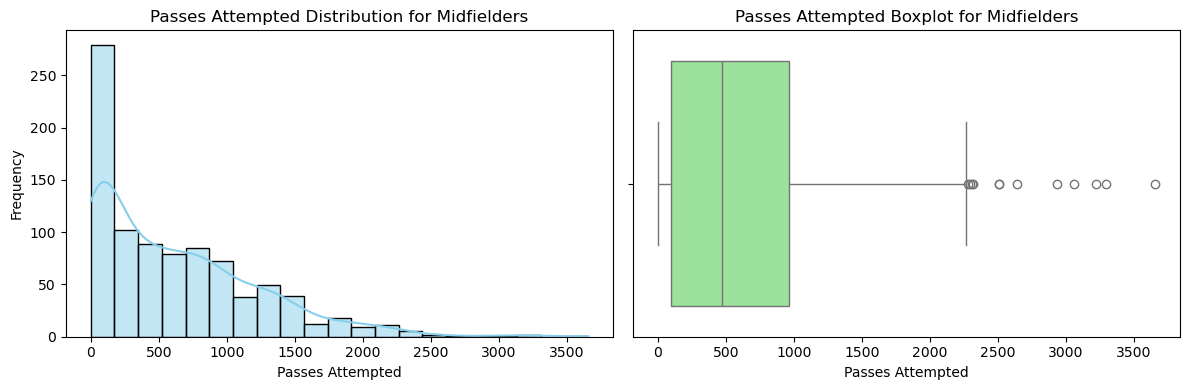

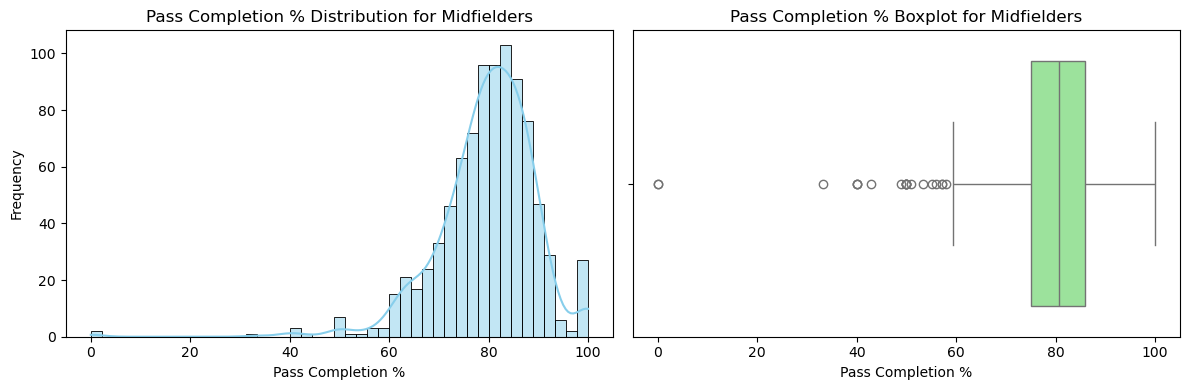

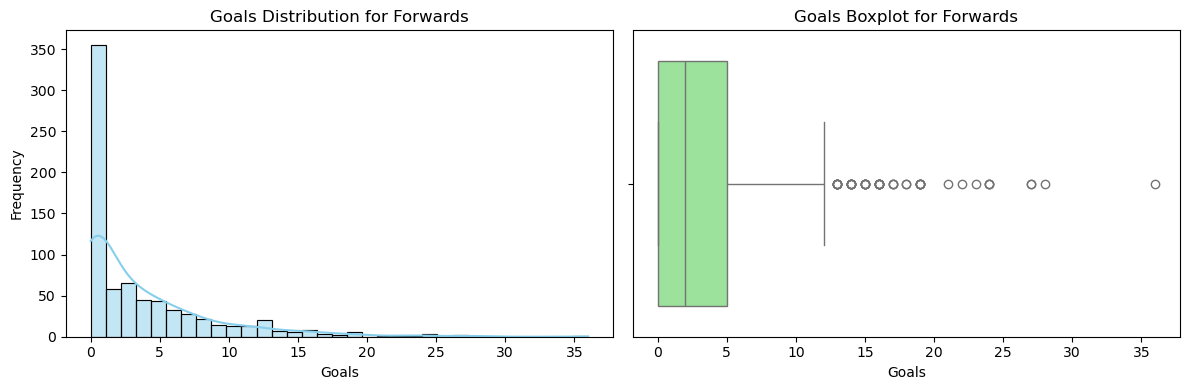

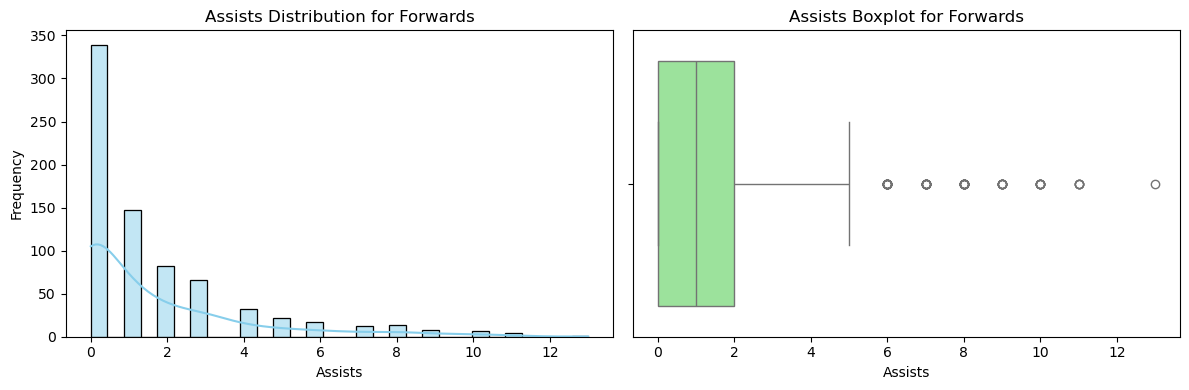

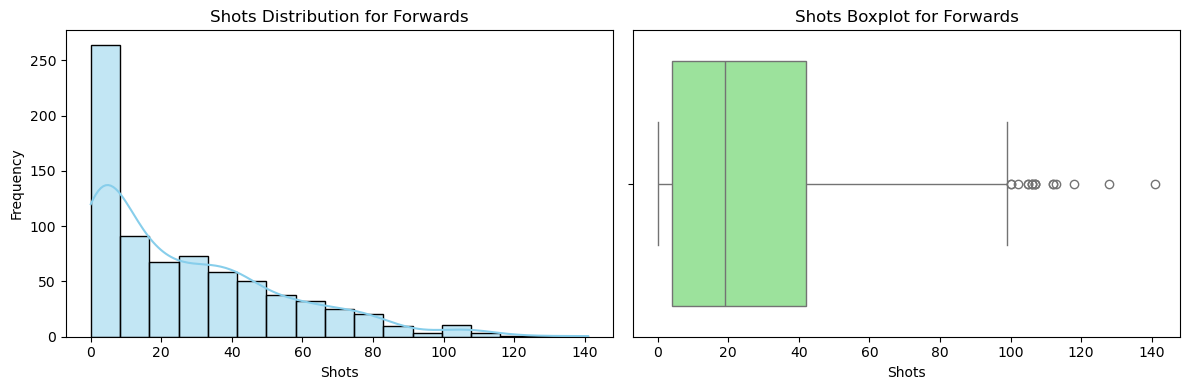

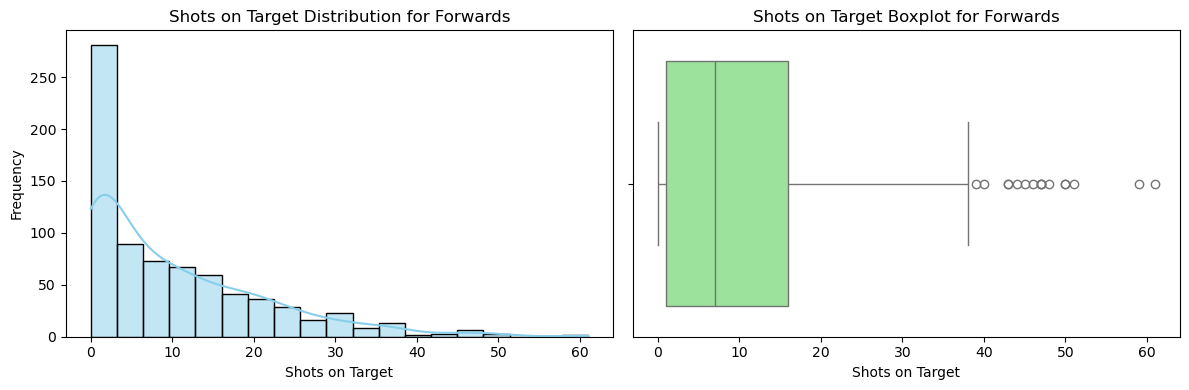

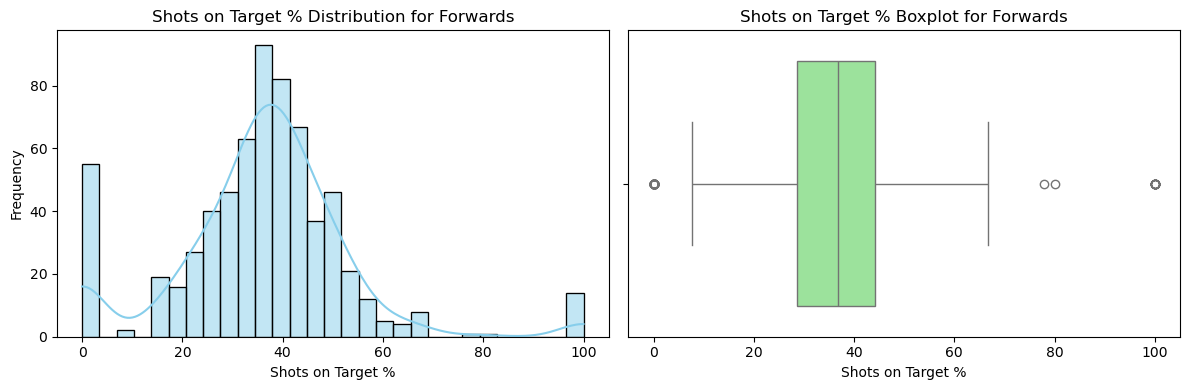

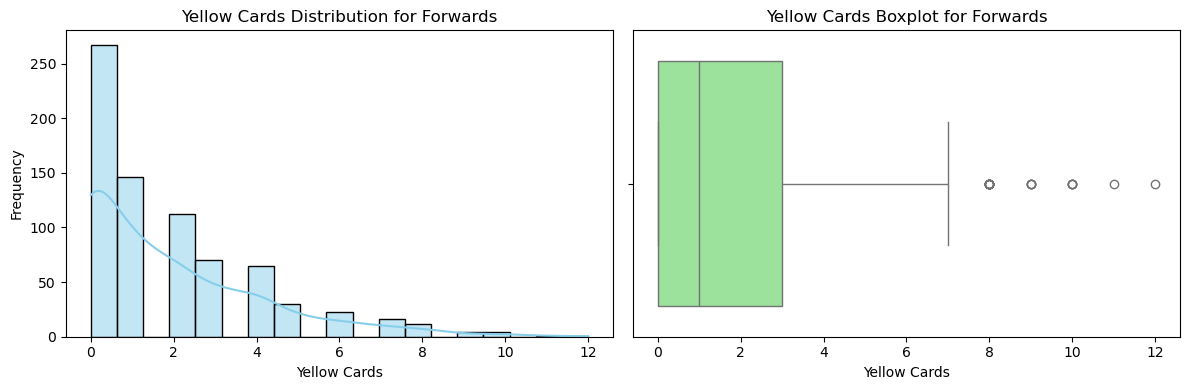

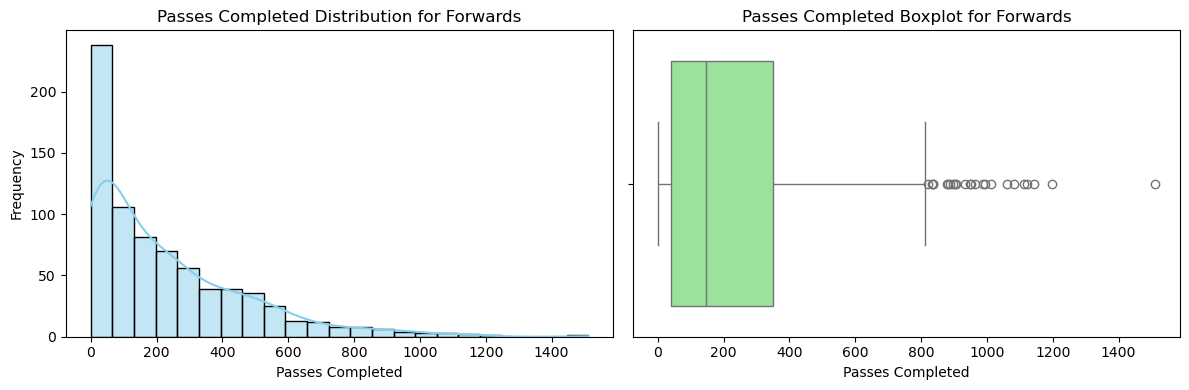

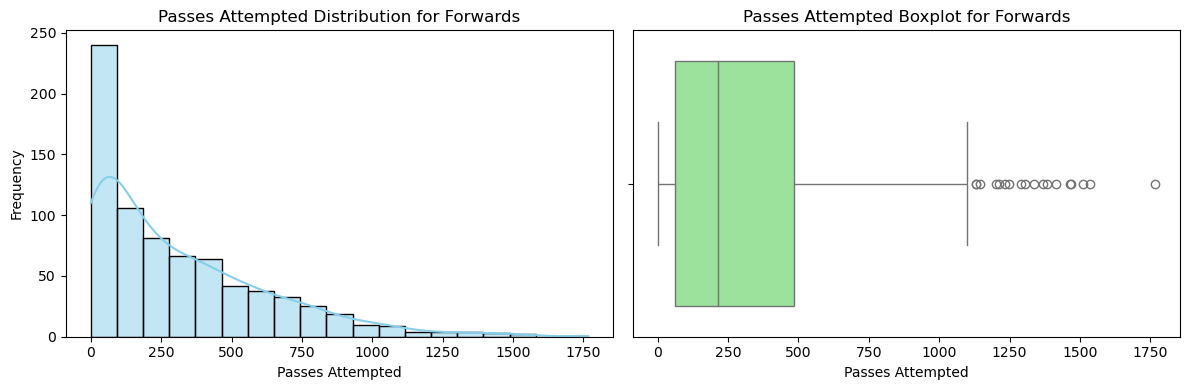

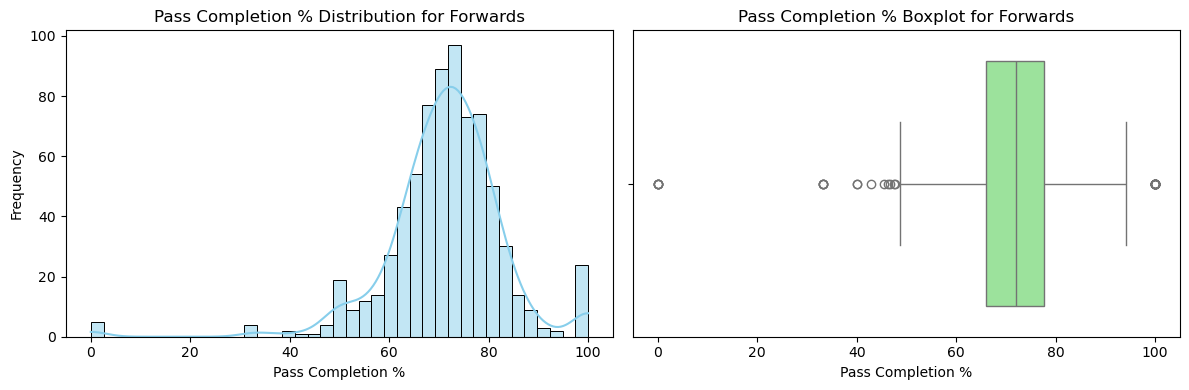

In [7]:

basic_stats = {
    'Goalkeepers': ['Goals Allowed', 'Saves Made', 'Save Percentage', 'Clean Sheets', 'Goals Allowed per 90 Minutes'],
    'Defenders': ['Goals', 'Assists', 'Yellow Cards', 'Red Cards', 'Tackles', 'Tackles Won', 'Interceptions', 'Clearances'],
    'Midfielders': ['Goals', 'Assists', 'Shots', 'Shots on Target', 'Yellow Cards', 'Tackles', 'Tackles Won', 'Passes Completed', 'Passes Attempted', 'Pass Completion %'],
    'Forwards': ['Goals', 'Assists', 'Shots', 'Shots on Target', 'Shots on Target %', 'Yellow Cards', 'Passes Completed', 'Passes Attempted', 'Pass Completion %']
}

def plot_and_save_plots(df, position, stats):
    for stat in stats:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        label = column_mapping.get(stat, stat)

        # histogram
        sns.histplot(df[stat].dropna(), kde=True, ax=axes[0], color="skyblue")
        axes[0].set_title(f'{label} Distribution for {position}')
        axes[0].set_xlabel(label)
        axes[0].set_ylabel('Frequency')

        # boxplot
        sns.boxplot(x=df[stat].dropna(), ax=axes[1], color="lightgreen")
        axes[1].set_title(f'{label} Boxplot for {position}')
        axes[1].set_xlabel(label)

        plt.tight_layout()

        # saving plots
        filename = f"plots/{position}_{stat}_EDA.png".replace(" ", "_")
        plt.savefig(filename, format='png', dpi=300)
        plt.show()


for position, df in dataframes.items():
    plot_and_save_plots(df, position, basic_stats[position])


<a id="correlation-heatmaps"></a>

## <div class='section'>Section 7: Correlation Heatmaps</div>

[Return to contents](#contents)

Finally, we create correlation heatmaps to explore any positive or negative relationships between features that may be useful for further analysis or model building.


In [8]:
def save_correlation_heatmap(df, position, stats):
    df_filtered = df[stats]
    corr = df_filtered.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True,
                linewidths=0.5, annot_kws={"size": 8})
    plt.title(f'Correlation Heatmap for {position}', fontweight='bold', fontsize=14)
    plt.tight_layout()
    filename = f"heatmap/{position}_correlation_heatmap.png".replace(" ", "_")
    plt.savefig(filename, format='png', dpi=300)
    plt.close()

# generating and saving correlation heatmaps for each position
for position, df in dataframes.items():
    print(f"Generating correlation heatmap for {position}...")
    # save_correlation_heatmap(df, position, basic_stats[position])

print("All correlation heatmaps have been saved as PNG files.")


Generating correlation heatmap for Goalkeepers...
Generating correlation heatmap for Defenders...
Generating correlation heatmap for Midfielders...
Generating correlation heatmap for Forwards...
All correlation heatmaps have been saved as PNG files.


<a id="PCA"></a>

## <div class='section'>Section 8: Principal Component Analysis</div>

[Return to contents](#contents)

<a id="defense-pca"></a>

### <div class='subsection'>8.1 Defense PCA</div>

In this section we split the defender data into training and testing data and do a PCA analysis on the training data. 

[Return to Section 8](#PCA)

The total number of components is: 44.
The number of components required to explain 95% of the variance is: 15.


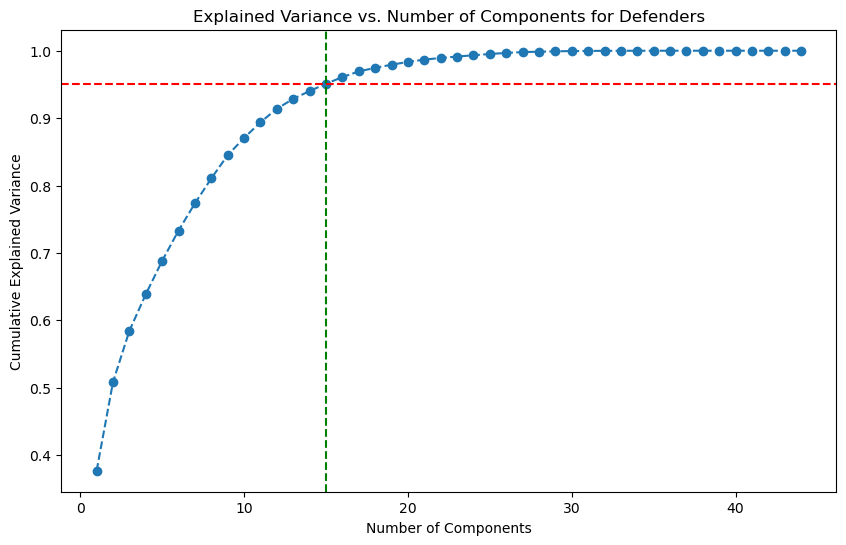

In [9]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

defender_train, defender_test = train_test_split(defenders, test_size=0.2, random_state=42)

defender_numeric_train = defender_train.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').drop(columns=['Annual Wage (Euros)'], errors='ignore').dropna()
defender_numeric_test = defender_test.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').drop(columns=['Annual Wage (Euros)'], errors='ignore').dropna()


defender_train = defender_train.loc[defender_numeric_train.index].reset_index(drop=True)
defender_test = defender_test.loc[defender_numeric_test.index].reset_index(drop=True)


defender_y_train = defender_train['Annual Wage (Euros)']
defender_y_test = defender_test['Annual Wage (Euros)']

pca = PCA()
defender_pca= pca.fit_transform(defender_numeric_train)
defender_pca1= pca.transform(defender_numeric_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

defender_valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {defender_valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=defender_valid_components, color='g', linestyle='--', label=f'{defender_valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Defenders')
plt.show()

In order to explain 95% of the variancee, only 15 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model, and these principal components will be used in our baseline models as well. 

In [10]:
defender_train['PC1'] = defender_pca[:, 0]
defender_train['PC2'] = defender_pca[:, 1]

defender_test['PC1'] = defender_pca1[:, 0]
defender_test['PC2'] = defender_pca1[:, 1]

top_defenders = defender_train.nlargest(10, 'PC1')

print("Top 10 defenders based on PC1:")
print(top_defenders[['Player', 'PC1']])

Top 10 defenders based on PC1:
                     Player     PC1
355           Álex Grimaldo  16.477
289             Pedro Porro  13.702
221     Giovanni Di Lorenzo  11.757
757        Jeremie Frimpong  11.102
260        Antonee Robinson  10.345
413              David Raum  10.148
112         Kieran Trippier   9.912
454  Trent Alexander-Arnold   9.876
335           Alfie Doughty   9.801
55           Theo Hernández   9.550


We thought that this this information would be interesting to note so that when we did our later comparisons we could have another metric to use to compare models with each other. These players also tend to be higher-performing.

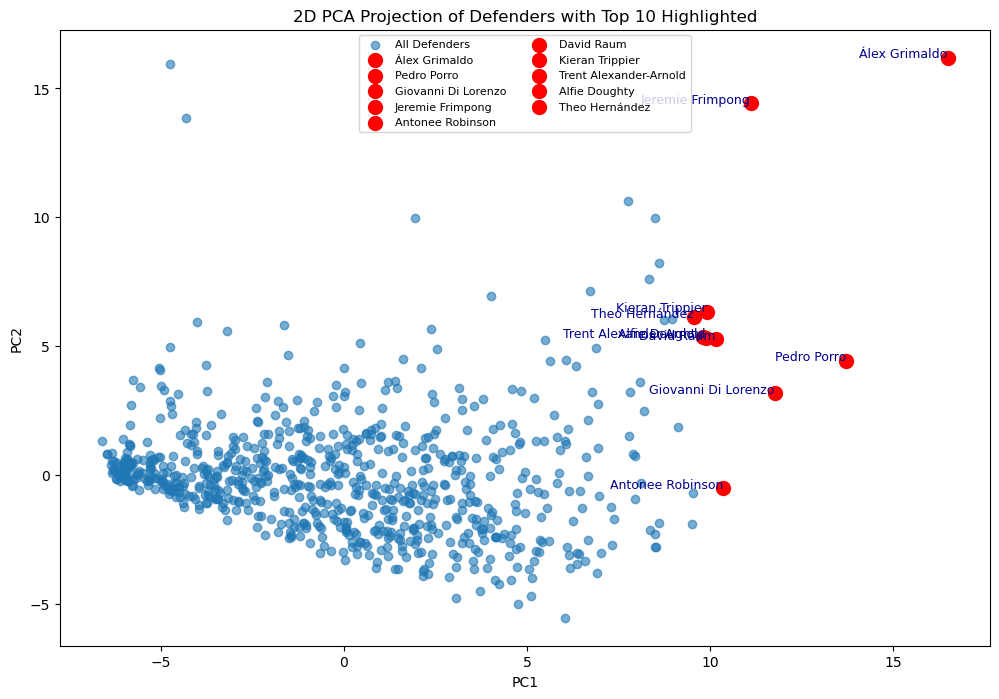

In [11]:
plt.figure(figsize=(12, 8))
plt.scatter(defender_pca[:, 0], defender_pca[:, 1], alpha=0.6, label="All Defenders")

for _, row in top_defenders.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Defenders with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

This plot demonstrates that most of the defenders are clustered and spread outwards. It is also apparent that there are no distinct groups outside of the large mass. However, the "top" defenders are at the edges of the cluster due to their high PC1 values. It is interesting to investigate why our higher performing athletes tend to be on the outskirts of the PCA. 

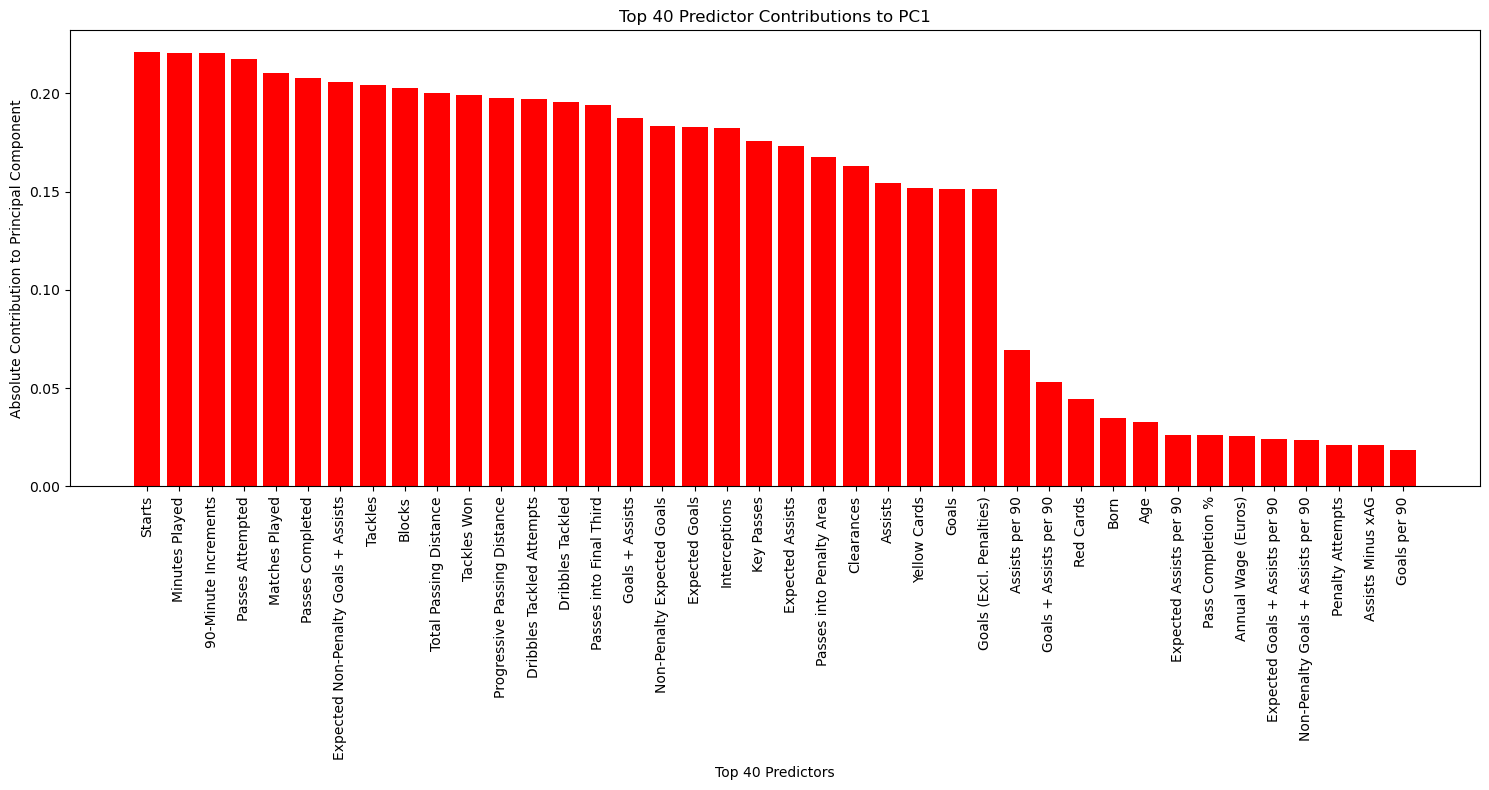

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = defender_train.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

Here, we can see the most important features to our first principal components. This gives us an idea of what features contribute most to the variance within athletes.

<a id="midfielder-pca"></a>

### <div class='subsection'>8.2 Midfielder PCA</div>

In this section we split the midfielder data into training and testing data and do a PCA analysis on the training data. 

[Return to Section 8](#PCA)

The total number of components is: 72.
The number of components required to explain 95% of the variance is: 20.


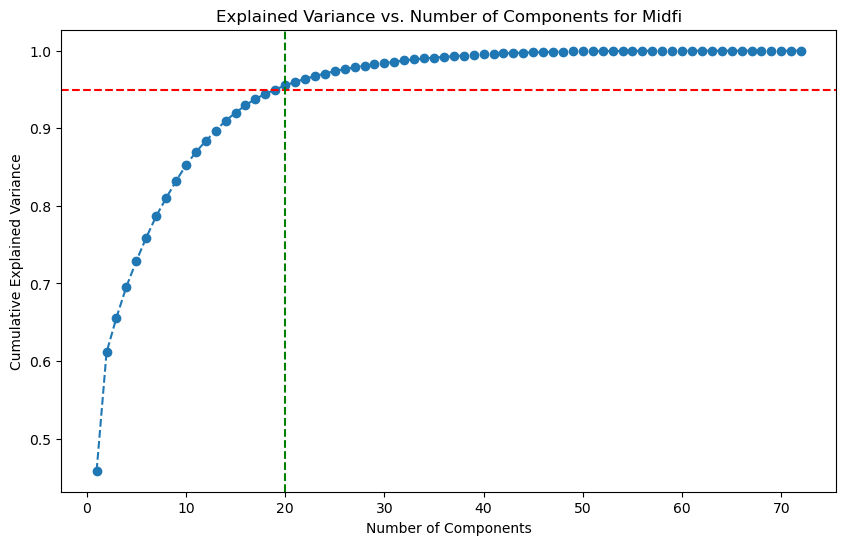

In [13]:
midfielders_train, midfielders_test = train_test_split(midfielders, test_size=0.2, random_state=42)

midfielders_numeric_train = midfielders_train.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').drop(columns=['Annual Wage (Euros)'], errors='ignore').dropna()
midfielders_numeric_test = midfielders_test.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').drop(columns=['Annual Wage (Euros)'], errors='ignore').dropna()


midfielders_train = midfielders_train.loc[midfielders_numeric_train.index].reset_index(drop=True)
midfielders_test = midfielders_test.loc[midfielders_numeric_test.index].reset_index(drop=True)


midfielders_y_train = midfielders_train['Annual Wage (Euros)']
midfielders_y_test = midfielders_test['Annual Wage (Euros)']

pca = PCA()
midfielders_pca= pca.fit_transform(midfielders_numeric_train)
midfielders_pca1= pca.transform(midfielders_numeric_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

midfielders_valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {midfielders_valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=midfielders_valid_components, color='g', linestyle='--', label=f'{midfielders_valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Midfi')
plt.show()

In order to explain 95% of the variancee, only 20 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model, and these principal components will be used in our baseline models as well. 

In [14]:
midfielders_train['PC1'] = midfielders_pca[:, 0]
midfielders_train['PC2'] = midfielders_pca[:, 1]

midfielders_test['PC1'] = midfielders_pca1[:, 0]
midfielders_test['PC2'] = midfielders_pca1[:, 1]

top_midfielders = midfielders_train.nlargest(10, 'PC1')

print("Top 10 midfielders based on PC1:")
print(top_midfielders[['Player', 'PC1']])

Top 10 midfielders based on PC1:
              Player     PC1
132            Rodri  19.005
106  Bruno Fernandes  17.779
555      Pascal Groß  17.695
242    Florian Wirtz  16.482
524  Martin Ødegaard  16.117
63   Bruno Guimarães  16.047
197      Xavi Simons  15.146
554      Declan Rice  14.049
439     Kevin Stöger  13.899
410    Téji Savanier  13.802


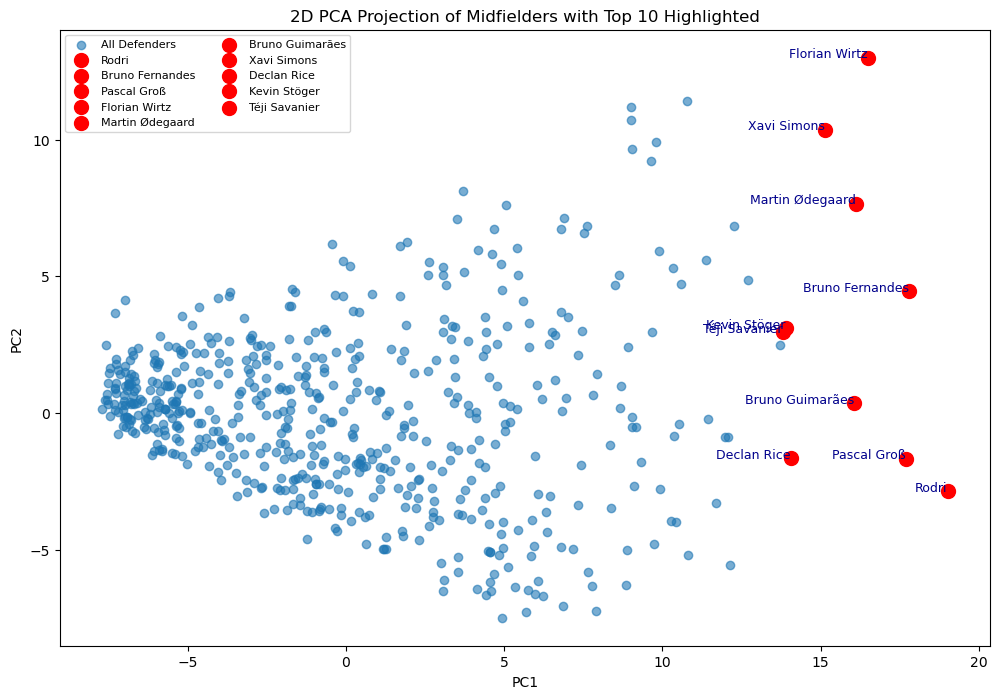

In [15]:
# graphing PCA with names
plt.figure(figsize=(12, 8))
plt.scatter(midfielders_pca[:, 0], midfielders_pca[:, 1], alpha=0.6, label="All Defenders")

for _, row in top_midfielders.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Midfielders with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

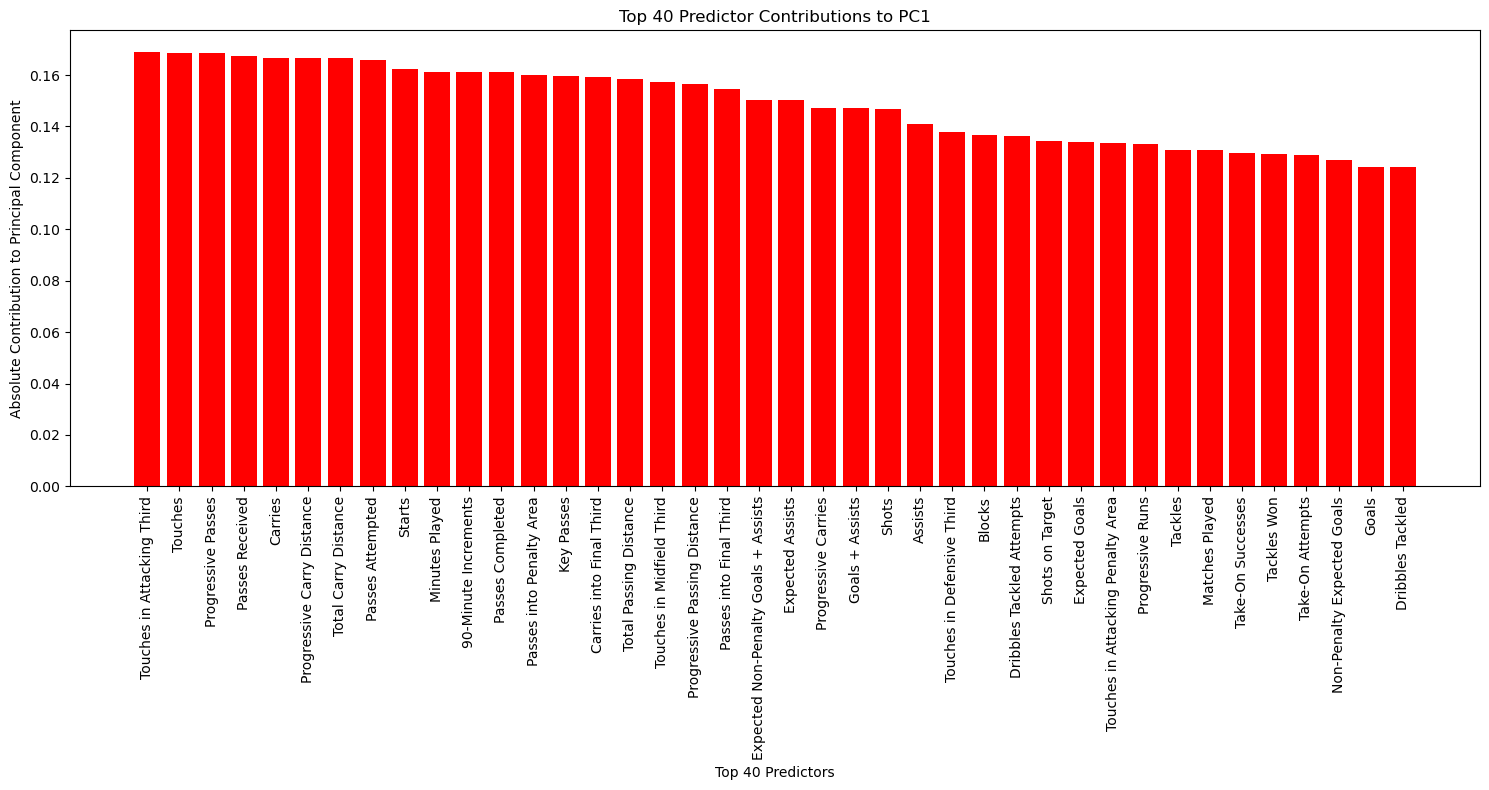

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = midfielders_train.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

<a id="goalkeeper-pca"></a>

### <div class='subsection'>8.3 Goalkeeper PCA</div>

In this section we split the goalkeeper data into training and testing data and do a PCA analysis on the training data.

[Return to Section 8](#PCA)

The total number of components is: 20.
The number of components required to explain 95% of the variance is: 7.


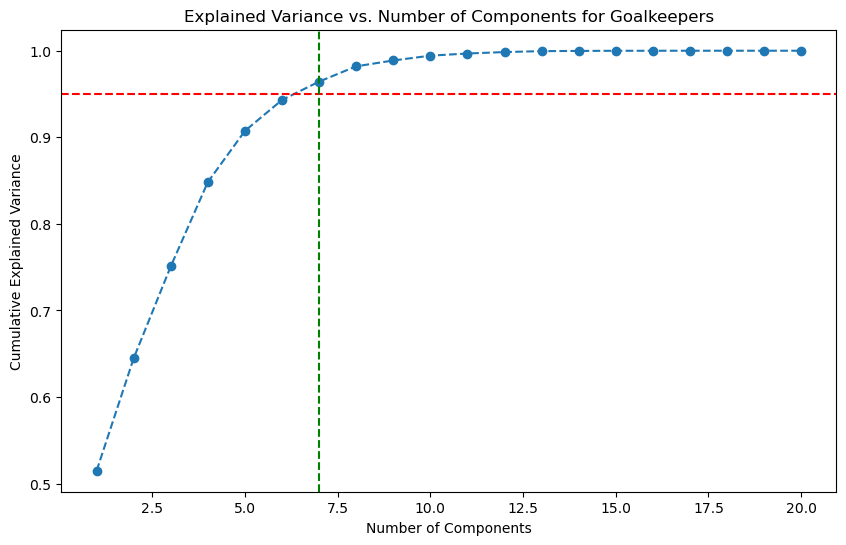

In [17]:
from sklearn.decomposition import PCA

goalkeepers_train, goalkeepers_test = train_test_split(goalkeepers, test_size=0.2, random_state=42)

goalkeepers_numeric_train = goalkeepers_train.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').drop(columns=['Annual Wage (Euros)'], errors='ignore').dropna()
goalkeepers_numeric_test = goalkeepers_test.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').drop(columns=['Annual Wage (Euros)'], errors='ignore').dropna()


goalkeepers_train = goalkeepers_train.loc[goalkeepers_numeric_train.index].reset_index(drop=True)
goalkeepers_test = goalkeepers_test.loc[goalkeepers_numeric_test.index].reset_index(drop=True)


goalkeepers_y_train = goalkeepers_train['Annual Wage (Euros)']
goalkeepers_y_test = goalkeepers_test['Annual Wage (Euros)']

pca = PCA()
goalkeepers_pca= pca.fit_transform(goalkeepers_numeric_train)
goalkeepers_pca1= pca.transform(goalkeepers_numeric_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

goalkeepers_valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {goalkeepers_valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=goalkeepers_valid_components, color='g', linestyle='--', label=f'{goalkeepers_valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Goalkeepers')
plt.show()

In order to explain 95% of the variancee, only 7 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model, and these principal components will be used in our baseline models as well. 

In [18]:
goalkeepers_train['PC1'] = goalkeepers_pca[:, 0]
goalkeepers_train['PC2'] = goalkeepers_pca[:, 1]

goalkeepers_test['PC1'] = goalkeepers_pca1[:, 0]
goalkeepers_test['PC2'] = goalkeepers_pca1[:, 1]

top_goalkeepers= goalkeepers_train.nlargest(10, 'PC1')

print("Top 10 defenders based on PC1:")
print(top_goalkeepers[['Player', 'PC1']])

Top 10 defenders based on PC1:
                Player    PC1
119    Filip Jørgensen  5.098
118    Thomas Kaminski  4.904
9      Paulo Gazzaniga  4.815
88     Jordan Pickford  4.780
60          Bernd Leno  4.561
114  Guglielmo Vicario  4.554
145         Yvon Mvogo  4.501
27      Oliver Baumann  4.472
109  Alexandre Oukidja  4.367
54   Wladimiro Falcone  4.251


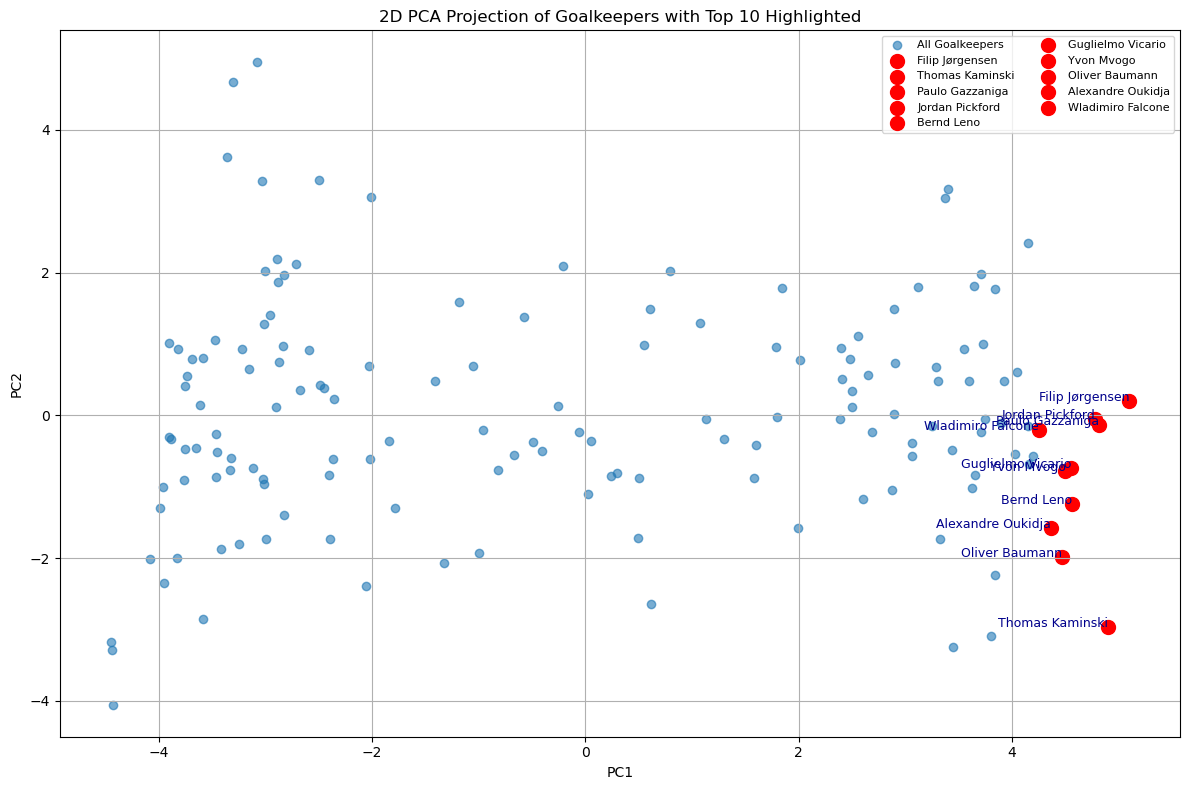

In [19]:
plt.figure(figsize=(12, 8))

plt.scatter(goalkeepers_pca[:, 0], goalkeepers_pca[:, 1], alpha=0.6, label="All Goalkeepers")

for _, row in top_goalkeepers.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
    

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Goalkeepers with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.grid()
plt.tight_layout()
plt.show()

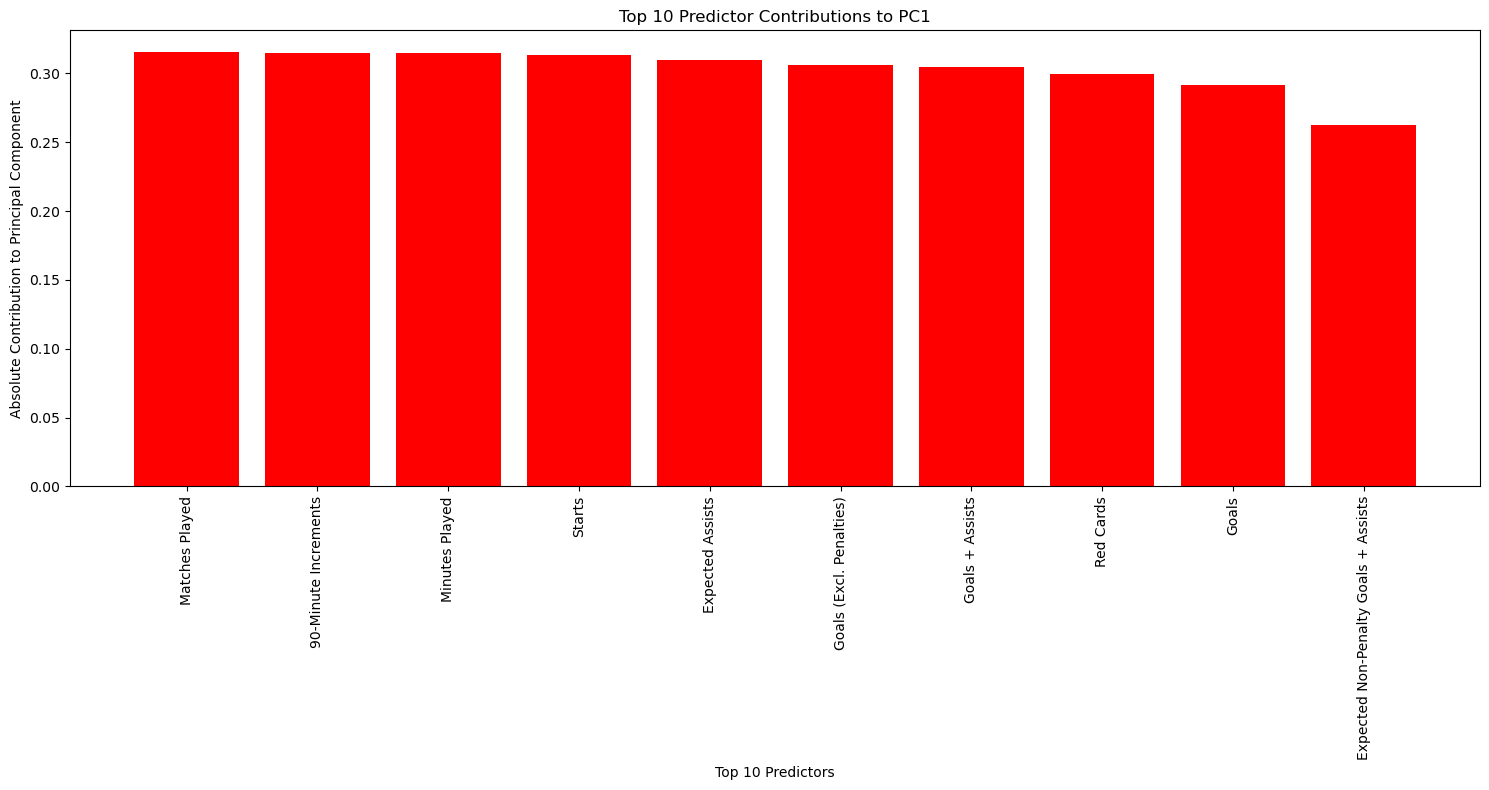

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-10:][::-1]
top_features = defender_train.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 10 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 10 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

<a id="forward-pca-2"></a>

### <div class='subsection'>8.4 Forward PCA</div>


In this section we split the defender data into training and testing data and do a PCA analysis on the training data. 

[Return to Section 8](#PCA)

The total number of components is: 63.
The number of components required to explain 95% of the variance is: 17.


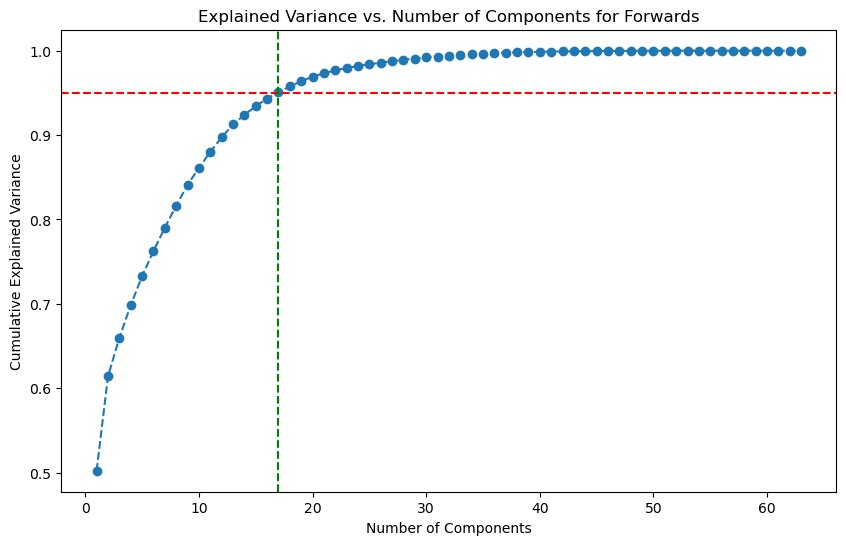

In [21]:
forwards_train, forwards_test = train_test_split(forwards, test_size=0.2, random_state=42)

forwards_numeric_train = forwards_train.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').drop(columns=['Annual Wage (Euros)'], errors='ignore').dropna()
forwards_numeric_test = forwards_test.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').drop(columns=['Annual Wage (Euros)'], errors='ignore').dropna()


forwards_train = forwards_train.loc[forwards_numeric_train.index].reset_index(drop=True)
forwards_test = forwards_test.loc[forwards_numeric_test.index].reset_index(drop=True)


forwards_y_train = forwards_train['Annual Wage (Euros)']
forwards_y_test = forwards_test['Annual Wage (Euros)']

pca = PCA()
pca1 = PCA()
forwards_pca= pca.fit_transform(forwards_numeric_train)
forwards_pca1= pca1.fit_transform(forwards_numeric_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

forwards_valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {forwards_valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=forwards_valid_components, color='g', linestyle='--', label=f'{forwards_valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Forwards')
plt.show()

In order to explain 95% of the variance, only 17 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model, and these principal components will be used in our baseline models as well. 

In [22]:
forwards_train['PC1'] = forwards_pca[:, 0]
forwards_train['PC2'] = forwards_pca[:, 1]

forwards_test['PC1'] = forwards_pca1[:, 0]
forwards_test['PC2'] = forwards_pca1[:, 1]

top_forwards = forwards_train.nlargest(10, 'PC1')

print("Top 10 defenders based on PC1:")
print(top_forwards[['Player', 'PC1']])

Top 10 defenders based on PC1:
                  Player     PC1
265          Cole Palmer  18.785
345          Bukayo Saka  18.558
419           Phil Foden  17.301
489         Matìas Soulé  16.947
77         Kylian Mbappé  15.290
280        Mohamed Salah  15.108
148                Sávio  14.487
308  Romain Del Castillo  14.322
349        Son Heung-min  13.964
256           Harry Kane  13.637


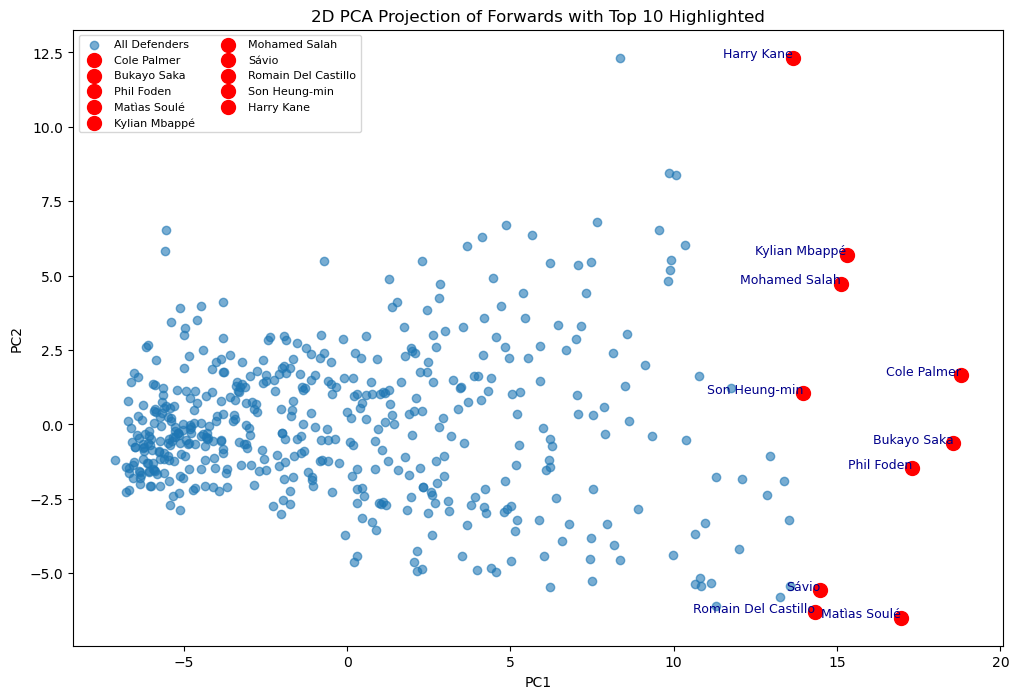

In [23]:
plt.figure(figsize=(12, 8))
plt.scatter(forwards_pca[:, 0], forwards_pca[:, 1], alpha=0.6, label="All Defenders")

for _, row in top_forwards.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Forwards with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

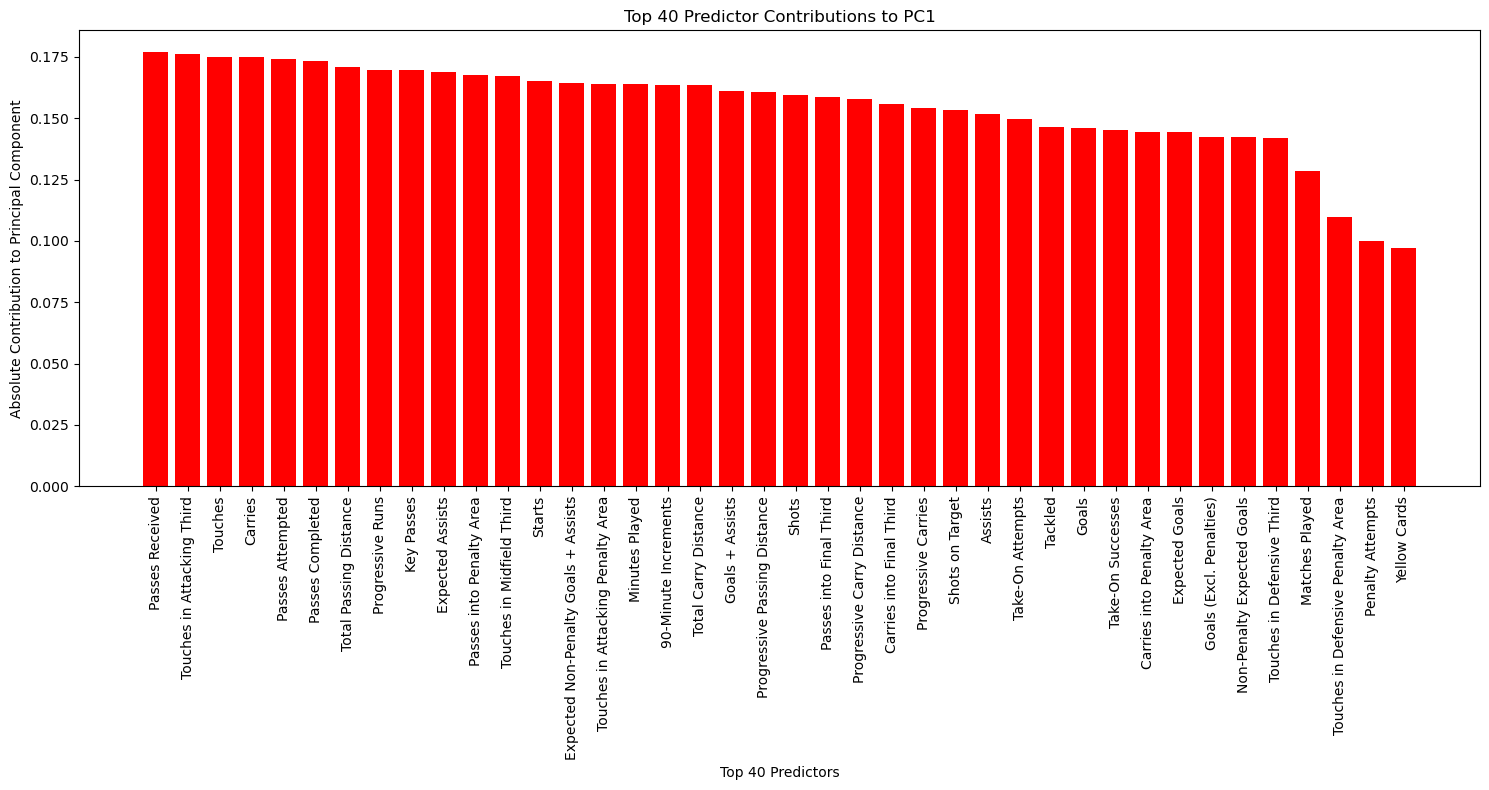

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-min(40, len(forwards_train.columns)):][::-1]
top_features = forwards_train.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

<a id="baseline-models"></a>

## <div class='section'>Section 9: Baseline Modeling</div>

[Return to contents](#contents)


### <a id="baseline-models-defense-dt"></a> 9.1.A Defensive Player Decision Tree

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


pca = PCA(n_components=defender_valid_components)
x_train = pca.fit_transform(defender_numeric_train)
x_test = pca.transform(defender_numeric_test)
y_train = defender_y_train
y_test = defender_y_test

df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        # Create a regression tree
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth)
        
        # cross_val_score by default for regressors returns the R² score
        scores = cross_val_score(dt, X=x_train, y=y_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

# Identify best depths for both criteria
best_squared_idx = np.argmax(df_squared['mean_cv'])
best_friedman_idx = np.argmax(df_friedman['mean_cv'])

best_depth_squared = df_squared['depth'].iloc[best_squared_idx]
best_depth_friedman = df_friedman['depth'].iloc[best_friedman_idx]

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error')
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse')

# Fit the models on the training data
model_tree_squared.fit(x_train, y_train)
model_tree_friedman.fit(x_train, y_train)

# Evaluate on the training set
train_pred_squared = model_tree_squared.predict(x_train)
train_pred_friedman = model_tree_friedman.predict(x_train)

r2_train_squared = r2_score(y_train, train_pred_squared)
r2_train_friedman = r2_score(y_train, train_pred_friedman)

cv_r2_squared = df_squared['mean_cv'].iloc[best_squared_idx]
cv_r2_friedman = df_friedman['mean_cv'].iloc[best_friedman_idx]

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

# Select the best model based on cross-validation R²
if cv_r2_squared >= cv_r2_friedman:
    model = model_tree_squared
else:
    model = model_tree_friedman

pred = model.predict(x_test)
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
print("\nTest R²: {:.4f}".format(test_r2))
print("Test MSE: {:.4f}".format(test_mse))

defenders_results_df = pd.DataFrame(columns=['model', 'r2', 'mse'])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)

# Save predictions - Now these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': defender_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('defenders_predictions_regression.csv', index=False)

================ [Squared Error (Using PCA)] ================
Training R²: 0.4257
Cross-Validation R²: 0.2078

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.4257
Cross-Validation R²: 0.2078

Test R²: -0.1929
Test MSE: 1.3669


/var/folders/76/j8v_j97d43zf045tm7sbcsfm0000gn/T/ipykernel_87731/549589381.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)


,model,r2,mse
0,Decision Tree,-0.193,1.367


The regression results indicate that the decision tree model struggles to generalize beyond the training data. Although the training R² of approximately 0.43 suggests that the model can capture some patterns within the training set, the cross-validation R² of around 0.21 shows a substantial drop in performance, indicating overfitting. More concerning is the negative R² (-0.19) on the test set, which implies that the model’s predictions are worse than a simple baseline that always predicts the mean value. This poor generalization, combined with the elevated training scores, strongly suggests that the decision tree regressor in its current form is not well suited for this annual wage prediction task. Further model refinement, feature engineering, or alternative modeling approaches are necessary to achieve more reliable and meaningful results.

### <a id="baseline-models-defense-bagging"></a> 9.1.B Defense Player Bagging Model

In [26]:
from sklearn.ensemble import BaggingRegressor

df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        # Create a regression tree
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth)
        
        # cross_val_score by default for regressors returns the R² score
        scores = cross_val_score(dt, X=x_train, y=y_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

# Identify best depths for both criteria
best_squared_idx = np.argmax(df_squared['mean_cv'])
best_friedman_idx = np.argmax(df_friedman['mean_cv'])

best_depth_squared = df_squared['depth'].iloc[best_squared_idx]
best_depth_friedman = df_friedman['depth'].iloc[best_friedman_idx]

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error')
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse')

# Fit the models on the training data
model_tree_squared.fit(x_train, y_train)
model_tree_friedman.fit(x_train, y_train)

# Evaluate on the training set
train_pred_squared = model_tree_squared.predict(x_train)
train_pred_friedman = model_tree_friedman.predict(x_train)

r2_train_squared = r2_score(y_train, train_pred_squared)
r2_train_friedman = r2_score(y_train, train_pred_friedman)

cv_r2_squared = df_squared['mean_cv'].iloc[best_squared_idx]
cv_r2_friedman = df_friedman['mean_cv'].iloc[best_friedman_idx]

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

# Select the best model based on cross-validation R²
if cv_r2_squared >= cv_r2_friedman:
    best_dt = model_tree_squared
else:
    best_dt = model_tree_friedman

# Now implement bagging with the best DT as the base estimator
bagged_model = BaggingRegressor(
    estimator=best_dt, 
    n_estimators=50,   # You can choose a different number of estimators
    random_state=42,
    n_jobs=-1
)

bagged_model.fit(x_train, y_train)
pred = bagged_model.predict(x_test)

test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
print("\nTest R² (Bagging): {:.4f}".format(test_r2))
print("Test MSE (Bagging): {:.4f}".format(test_mse))

new_row = pd.DataFrame({
    'model': ['Bagging (Decision Trees)'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)

# Save predictions - these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': defender_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('defenders_predictions_regression_bagging.csv', index=False)


================ [Squared Error (Using PCA)] ================
Training R²: 0.4257
Cross-Validation R²: 0.2069

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.4257
Cross-Validation R²: 0.2069

Test R² (Bagging): 0.0441
Test MSE (Bagging): 1.0953


,model,r2,mse
0,Decision Tree,-0.193,1.367
1,Bagging (Decision Trees),0.044,1.095


The results suggest that while the decision trees can capture some variance in the training data (with a training R² around 0.43) and achieve modest cross-validation scores (just above 0.20), the generalization to unseen data remains challenging. Even after employing bagging, the test R² is only about 0.04, indicating that the ensemble model explains very little of the variance in the test set. The test MSE of approximately 1.10 further highlights the gap between training and testing performance, suggesting that these models, in their current configurations, have limited predictive power for this particular task.

### <a id="baseline-models-defense-logreg"></a> 9.1.C Defensive Player Linear Regression Model

In [27]:
from sklearn.linear_model import LinearRegression

# Initialize and fit a Linear Regression model
lr = LinearRegression()
lr.fit(x_train, y_train)

# Predict continuous values
pred = lr.predict(x_test)

# Compute regression metrics
r2 = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)

# Create a new row for the results DataFrame
new_row = pd.DataFrame({
    'model': ['LinearReg'],  
    'r2': [round(r2,4)],
    'mse': [round(mse,4)],
})

# Concatenate with existing results
defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)

# Save predictions - these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': defender_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('defenders_predictions_linear_regression.csv', index=False)


,model,r2,mse
0,Decision Tree,-0.193,1.367
1,Bagging (Decision Trees),0.044,1.095
2,LinearReg,0.217,0.897


When using linear regression, we see that it is better at predicting the league of the players compared to the decision tree models, highlighting that it could be an optimal option for our model.

<a id="baseline-models-midfielder"></a>

## <div class='sub-section'>9.2: Midfielder Model Baselines (Decision Tree, Bagging, Logistic Regression)

### <a id="baseline-models-midfielder-dt"></a> 9.2.A Midfielder Player Decision Tree Baseline Model

In [28]:
pca = PCA(n_components=midfielders_valid_components)
x_train = pca.fit_transform(midfielders_numeric_train)
x_test = pca.transform(midfielders_numeric_test)
y_train = midfielders_y_train
y_test = midfielders_y_test

df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        # Create a regression tree
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth)
        
        # cross_val_score by default for regressors returns the R² score
        scores = cross_val_score(dt, X=x_train, y=y_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

# Identify best depths for both criteria
best_squared_idx = np.argmax(df_squared['mean_cv'])
best_friedman_idx = np.argmax(df_friedman['mean_cv'])

best_depth_squared = df_squared['depth'].iloc[best_squared_idx]
best_depth_friedman = df_friedman['depth'].iloc[best_friedman_idx]

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error')
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse')

# Fit the models on the training data
model_tree_squared.fit(x_train, y_train)
model_tree_friedman.fit(x_train, y_train)

# Evaluate on the training set
train_pred_squared = model_tree_squared.predict(x_train)
train_pred_friedman = model_tree_friedman.predict(x_train)

r2_train_squared = r2_score(y_train, train_pred_squared)
r2_train_friedman = r2_score(y_train, train_pred_friedman)

cv_r2_squared = df_squared['mean_cv'].iloc[best_squared_idx]
cv_r2_friedman = df_friedman['mean_cv'].iloc[best_friedman_idx]

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

# Select the best model based on cross-validation R²
if cv_r2_squared >= cv_r2_friedman:
    model = model_tree_squared
else:
    model = model_tree_friedman

pred = model.predict(x_test)
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
print("\nTest R²: {:.4f}".format(test_r2))
print("Test MSE: {:.4f}".format(test_mse))

midfielders_results_df = pd.DataFrame(columns=['model', 'r2', 'mse'])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)

# Save predictions - Now these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': midfielders_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('midfielders_predictions_regression.csv', index=False)

================ [Squared Error (Using PCA)] ================
Training R²: 0.5620
Cross-Validation R²: 0.1539

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.5620
Cross-Validation R²: 0.1539

Test R²: -0.4718
Test MSE: 1.4547


/var/folders/76/j8v_j97d43zf045tm7sbcsfm0000gn/T/ipykernel_87731/183764107.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)


,model,r2,mse
0,Decision Tree,-0.472,1.455


The midfielder model's performance metrics reveal a substantial discrepancy between training and evaluation phases, highlighting significant challenges in effectively predicting annual wages. With a training R² of approximately 0.66, the Decision Tree Regressor demonstrates a relatively strong ability to explain the variance within the training dataset, suggesting that the model captures meaningful patterns from the training data. However, this promising performance does not translate to unseen data, as evidenced by the cross-validation R² values of around 0.10 and a test R² of -0.25. The negative R² on the test set indicates that the model is performing worse than a simple baseline that always predicts the mean wage, underscoring severe overfitting issues. Additionally, the test Mean Squared Error (MSE) of 1.24 further emphasizes the model's poor predictive accuracy.

### <a id="baseline-models-midfielder-bagging"></a> 9.2.B Midfielder Player Bagging Baseline Model

In [29]:
df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        # Create a regression tree
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth)
        
        # cross_val_score by default for regressors returns the R² score
        scores = cross_val_score(dt, X=x_train, y=y_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

# Identify best depths for both criteria
best_squared_idx = np.argmax(df_squared['mean_cv'])
best_friedman_idx = np.argmax(df_friedman['mean_cv'])

best_depth_squared = df_squared['depth'].iloc[best_squared_idx]
best_depth_friedman = df_friedman['depth'].iloc[best_friedman_idx]

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error')
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse')

# Fit the models on the training data
model_tree_squared.fit(x_train, y_train)
model_tree_friedman.fit(x_train, y_train)

# Evaluate on the training set
train_pred_squared = model_tree_squared.predict(x_train)
train_pred_friedman = model_tree_friedman.predict(x_train)

r2_train_squared = r2_score(y_train, train_pred_squared)
r2_train_friedman = r2_score(y_train, train_pred_friedman)

cv_r2_squared = df_squared['mean_cv'].iloc[best_squared_idx]
cv_r2_friedman = df_friedman['mean_cv'].iloc[best_friedman_idx]

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

# Select the best model based on cross-validation R²
if cv_r2_squared >= cv_r2_friedman:
    best_dt = model_tree_squared
else:
    best_dt = model_tree_friedman

# Now implement bagging with the best DT as the base estimator
bagged_model = BaggingRegressor(
    estimator=best_dt, 
    n_estimators=50,   # You can choose a different number of estimators
    random_state=42,
    n_jobs=-1
)

bagged_model.fit(x_train, y_train)
pred = bagged_model.predict(x_test)

test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
print("\nTest R² (Bagging): {:.4f}".format(test_r2))
print("Test MSE (Bagging): {:.4f}".format(test_mse))

new_row = pd.DataFrame({
    'model': ['Bagging (Decision Trees)'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)

# Save predictions - these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': midfielders_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('midfielders_predictions_regression_bagging.csv', index=False)


================ [Squared Error (Using PCA)] ================
Training R²: 0.5620
Cross-Validation R²: 0.1539

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.4089
Cross-Validation R²: 0.0550

Test R² (Bagging): -0.1781
Test MSE (Bagging): 1.1643


,model,r2,mse
0,Decision Tree,-0.472,1.455
1,Bagging (Decision Trees),-0.178,1.164


The bagging model performed worse for the midfielders than the defenders, however the decision tree for the midfielders has a better r2 score than the decision tree for the defenders (even though both r2 scores are quite poor).

### <a id="baseline-models-midfielder-logreg"></a> 9.2.C Midfielder Player Linear Regression Baseline Model

In [30]:
# Initialize and fit a Linear Regression model
lr = LinearRegression()
lr.fit(x_train, y_train)

# Predict continuous values
pred = lr.predict(x_test)

# Compute regression metrics
r2 = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)

# Create a new row for the results DataFrame
new_row = pd.DataFrame({
    'model': ['LinearReg'],  
    'r2': [round(r2,4)],
    'mse': [round(mse,4)],
})

# Concatenate with existing results
midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)

# Save predictions - these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': midfielders_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('midfielders_predictions_linear_regression.csv', index=False)

,model,r2,mse
0,Decision Tree,-0.472,1.455
1,Bagging (Decision Trees),-0.178,1.164
2,LinearReg,0.209,0.782


Similar to the defenders data set, logistic regression outperforms the decision tree in terms of various accuracy metrics, indicating it's strength as a model. 

<a id="baseline-models-goalkeeper"></a>

## <div class='sub-section'>9.3: Goalkeeper Model Baselines (Decision Tree, Bagging, Logistic Regression)</div>



### <a id="baseline-models-goalkeeper-dt"></a> 9.3.A Goalkeeper Decision Tree Baseline Model

In [31]:
pca = PCA(n_components=goalkeepers_valid_components)
x_train = pca.fit_transform(goalkeepers_numeric_train)
x_test = pca.transform(goalkeepers_numeric_test)
y_train = goalkeepers_y_train
y_test = goalkeepers_y_test

df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        # Create a regression tree
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth)
        
        # cross_val_score by default for regressors returns the R² score
        scores = cross_val_score(dt, X=x_train, y=y_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

# Identify best depths for both criteria
best_squared_idx = np.argmax(df_squared['mean_cv'])
best_friedman_idx = np.argmax(df_friedman['mean_cv'])

best_depth_squared = df_squared['depth'].iloc[best_squared_idx]
best_depth_friedman = df_friedman['depth'].iloc[best_friedman_idx]

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error')
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse')

# Fit the models on the training data
model_tree_squared.fit(x_train, y_train)
model_tree_friedman.fit(x_train, y_train)

# Evaluate on the training set
train_pred_squared = model_tree_squared.predict(x_train)
train_pred_friedman = model_tree_friedman.predict(x_train)

r2_train_squared = r2_score(y_train, train_pred_squared)
r2_train_friedman = r2_score(y_train, train_pred_friedman)

cv_r2_squared = df_squared['mean_cv'].iloc[best_squared_idx]
cv_r2_friedman = df_friedman['mean_cv'].iloc[best_friedman_idx]

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

# Select the best model based on cross-validation R²
if cv_r2_squared >= cv_r2_friedman:
    model = model_tree_squared
else:
    model = model_tree_friedman

pred = model.predict(x_test)
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
print("\nTest R²: {:.4f}".format(test_r2))
print("Test MSE: {:.4f}".format(test_mse))

goalkeepers_results_df = pd.DataFrame(columns=['model', 'r2', 'mse'])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)

# Save predictions - Now these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': goalkeepers_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('goalkeepers_predictions_regression.csv', index=False)

================ [Squared Error (Using PCA)] ================
Training R²: 0.4403
Cross-Validation R²: -0.3486

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.4403
Cross-Validation R²: -0.3486

Test R²: -0.3738
Test MSE: 2.3928


/var/folders/76/j8v_j97d43zf045tm7sbcsfm0000gn/T/ipykernel_87731/1508083288.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)


,model,r2,mse
0,Decision Tree,-0.374,2.393


The Decision Tree model’s performance metrics reveal that the learned patterns do not generalize well. Although the training R² is around 0.44, indicating that the model captures some variance in the training data, both cross-validation and test R² values are negative. A negative R² means the model is performing worse than a simple baseline model that always predicts the mean value of the target variable. The substantial drop from training to cross-validation (and later to test) underscores severe overfitting and suggests that the model is not reliably capturing the underlying relationships necessary to predict goalkeeper wages. The test MSE of approximately 2.39 further supports the notion that the current model configuration is far from satisfactory, and that more robust feature engineering, hyperparameter tuning, or entirely different modeling approaches may be necessary.

### <a id="baseline-models-goalkeeper-bagging"></a> 9.3.B Goalkeeper Bagging Baseline Model

In [32]:
df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        # Create a regression tree
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth)
        
        # cross_val_score by default for regressors returns the R² score
        scores = cross_val_score(dt, X=x_train, y=y_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

# Identify best depths for both criteria
best_squared_idx = np.argmax(df_squared['mean_cv'])
best_friedman_idx = np.argmax(df_friedman['mean_cv'])

best_depth_squared = df_squared['depth'].iloc[best_squared_idx]
best_depth_friedman = df_friedman['depth'].iloc[best_friedman_idx]

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error')
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse')

# Fit the models on the training data
model_tree_squared.fit(x_train, y_train)
model_tree_friedman.fit(x_train, y_train)

# Evaluate on the training set
train_pred_squared = model_tree_squared.predict(x_train)
train_pred_friedman = model_tree_friedman.predict(x_train)

r2_train_squared = r2_score(y_train, train_pred_squared)
r2_train_friedman = r2_score(y_train, train_pred_friedman)

cv_r2_squared = df_squared['mean_cv'].iloc[best_squared_idx]
cv_r2_friedman = df_friedman['mean_cv'].iloc[best_friedman_idx]

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

# Select the best model based on cross-validation R²
if cv_r2_squared >= cv_r2_friedman:
    best_dt = model_tree_squared
else:
    best_dt = model_tree_friedman

# Now implement bagging with the best DT as the base estimator
bagged_model = BaggingRegressor(
    estimator=best_dt, 
    n_estimators=50,   # You can choose a different number of estimators
    random_state=42,
    n_jobs=-1
)

bagged_model.fit(x_train, y_train)
pred = bagged_model.predict(x_test)

test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
print("\nTest R² (Bagging): {:.4f}".format(test_r2))
print("Test MSE (Bagging): {:.4f}".format(test_mse))

new_row = pd.DataFrame({
    'model': ['Bagging (Decision Trees)'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)

# Save predictions - these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': goalkeepers_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('goalkeepers_predictions_regression_bagging.csv', index=False)


================ [Squared Error (Using PCA)] ================
Training R²: 0.4403
Cross-Validation R²: -0.3486

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.4403
Cross-Validation R²: -0.3486

Test R² (Bagging): 0.1172
Test MSE (Bagging): 1.5376


,model,r2,mse
0,Decision Tree,-0.374,2.393
1,Bagging (Decision Trees),0.117,1.538


The bagging model performs very well on the goalkeeper data relatove to the decision tree model which may be due to the simpler nature of the data set.

### <a id="baseline-models-goalkeeper-logreg"></a> 9.3.C Goalkeeper Linear Regression Baseline Model

In [33]:
# Initialize and fit a Linear Regression model
lr = LinearRegression()
lr.fit(x_train, y_train)

# Predict continuous values
pred = lr.predict(x_test)

# Compute regression metrics
r2 = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)

# Create a new row for the results DataFrame
new_row = pd.DataFrame({
    'model': ['LinearReg'],  
    'r2': [round(r2,4)],
    'mse': [round(mse,4)],
})

# Concatenate with existing results
goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)

# Save predictions - these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': goalkeepers_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('goalkeepers_predictions_linear_regression.csv', index=False)


,model,r2,mse
0,Decision Tree,-0.374,2.393
1,Bagging (Decision Trees),0.117,1.538
2,LinearReg,0.081,1.601


It appears the bagging model is the best model for the goalkeeper data thus far although it still has a lot of room for improvement given it's very low r2 score. The Linear model is next best with a comparably low MSE but a noticeable lower r2 score than the bagging model. The decision tree model is clearly the worst model, having the worst r2 and MSE scores.

<a id="baseline-models-forward"></a>

#### <div class='sub-section'>8.4: Forward Model Baselines (Decision Tree, Bagging, Logistic Regression)</div>


### <a id="baseline-models-forward-dt"></a> 9.4.A Forward Player Decision Tree Baseline Model

In [34]:
pca = PCA(n_components=forwards_valid_components)
x_train = pca.fit_transform(forwards_numeric_train)
x_test = pca.transform(forwards_numeric_test)
y_train = forwards_y_train
y_test = forwards_y_test

df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        # Create a regression tree
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth)
        
        # cross_val_score by default for regressors returns the R² score
        scores = cross_val_score(dt, X=x_train, y=y_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

# Identify best depths for both criteria
best_squared_idx = np.argmax(df_squared['mean_cv'])
best_friedman_idx = np.argmax(df_friedman['mean_cv'])

best_depth_squared = df_squared['depth'].iloc[best_squared_idx]
best_depth_friedman = df_friedman['depth'].iloc[best_friedman_idx]

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error')
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse')

# Fit the models on the training data
model_tree_squared.fit(x_train, y_train)
model_tree_friedman.fit(x_train, y_train)

# Evaluate on the training set
train_pred_squared = model_tree_squared.predict(x_train)
train_pred_friedman = model_tree_friedman.predict(x_train)

r2_train_squared = r2_score(y_train, train_pred_squared)
r2_train_friedman = r2_score(y_train, train_pred_friedman)

cv_r2_squared = df_squared['mean_cv'].iloc[best_squared_idx]
cv_r2_friedman = df_friedman['mean_cv'].iloc[best_friedman_idx]

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

# Select the best model based on cross-validation R²
if cv_r2_squared >= cv_r2_friedman:
    model = model_tree_squared
else:
    model = model_tree_friedman

pred = model.predict(x_test)
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
print("\nTest R²: {:.4f}".format(test_r2))
print("Test MSE: {:.4f}".format(test_mse))

forwards_results_df = pd.DataFrame(columns=['model', 'r2', 'mse'])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)

# Save predictions - Now these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': forwards_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('forwards_predictions_regression.csv', index=False)

================ [Squared Error (Using PCA)] ================
Training R²: 0.5941
Cross-Validation R²: -1.1892

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.5941
Cross-Validation R²: -1.1892

Test R²: -2.1194
Test MSE: 2.7792


/var/folders/76/j8v_j97d43zf045tm7sbcsfm0000gn/T/ipykernel_87731/2798168860.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)


,model,r2,mse
0,Decision Tree,-2.119,2.779


The decision tree model’s performance metrics indicate significant challenges in capturing and generalizing the underlying patterns necessary for accurate wage prediction. With a training R² of approximately 0.59, the Decision Tree Regressor demonstrates a moderate ability to explain the variance within the training dataset. However, this promising performance sharply declines during cross-validation, where the R² plummets to -1.19, and further deteriorates on the test set with an R² of -0.19. Negative R² values in both cross-validation and testing phases signify that the model performs worse than a naive baseline that simply predicts the mean wage, highlighting severe overfitting issues. Additionally, the test Mean Squared Error (MSE) of 1.06 underscores the model's poor predictive accuracy.

### <a id="baseline-models-forward-bagging"></a> 9.4.B Forward Player Bagging Baseline Model

In [35]:
df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        # Create a regression tree
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth)
        
        # cross_val_score by default for regressors returns the R² score
        scores = cross_val_score(dt, X=x_train, y=y_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

# Identify best depths for both criteria
best_squared_idx = np.argmax(df_squared['mean_cv'])
best_friedman_idx = np.argmax(df_friedman['mean_cv'])

best_depth_squared = df_squared['depth'].iloc[best_squared_idx]
best_depth_friedman = df_friedman['depth'].iloc[best_friedman_idx]

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error')
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse')

# Fit the models on the training data
model_tree_squared.fit(x_train, y_train)
model_tree_friedman.fit(x_train, y_train)

# Evaluate on the training set
train_pred_squared = model_tree_squared.predict(x_train)
train_pred_friedman = model_tree_friedman.predict(x_train)

r2_train_squared = r2_score(y_train, train_pred_squared)
r2_train_friedman = r2_score(y_train, train_pred_friedman)

cv_r2_squared = df_squared['mean_cv'].iloc[best_squared_idx]
cv_r2_friedman = df_friedman['mean_cv'].iloc[best_friedman_idx]

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

# Select the best model based on cross-validation R²
if cv_r2_squared >= cv_r2_friedman:
    best_dt = model_tree_squared
else:
    best_dt = model_tree_friedman

# Now implement bagging with the best DT as the base estimator
bagged_model = BaggingRegressor(
    estimator=best_dt, 
    n_estimators=50,   # You can choose a different number of estimators
    random_state=42,
    n_jobs=-1
)

bagged_model.fit(x_train, y_train)
pred = bagged_model.predict(x_test)

test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
print("\nTest R² (Bagging): {:.4f}".format(test_r2))
print("Test MSE (Bagging): {:.4f}".format(test_mse))

new_row = pd.DataFrame({
    'model': ['Bagging (Decision Trees)'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)

# Save predictions - these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': forwards_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('forwards_predictions_regression_bagging.csv', index=False)


================ [Squared Error (Using PCA)] ================
Training R²: 0.5941
Cross-Validation R²: -1.1892

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.5941
Cross-Validation R²: -1.1892

Test R² (Bagging): -0.3108
Test MSE (Bagging): 1.1678


,model,r2,mse
0,Decision Tree,-2.119,2.779
1,Bagging (Decision Trees),-0.311,1.168


The bagging model is worse all around than the decision tree model.

### <a id="baseline-models-forward-logreg"></a> 9.4.C Forward Player Linear Regression Baseline Model

In [36]:
# Initialize and fit a Linear Regression model
lr = LinearRegression()
lr.fit(x_train, y_train)

# Predict continuous values
pred = lr.predict(x_test)

# Compute regression metrics
r2 = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)

# Create a new row for the results DataFrame
new_row = pd.DataFrame({
    'model': ['LinearReg'],  
    'r2': [round(r2,4)],
    'mse': [round(mse,4)],
})

# Concatenate with existing results
forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)

# Save predictions - these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': forwards_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('forwards_predictions_linear_regression.csv', index=False)



,model,r2,mse
0,Decision Tree,-2.119,2.779
1,Bagging (Decision Trees),-0.311,1.168
2,LinearReg,0.203,0.710


On the forwards, the linear regression performs the best out of the 3 models, although it's r2 score can be heavily improved.